# Importlar ve ön hazırlık

In [45]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
import warnings


def hazirlik():
    """
    Veri setlerini okumak, gereksiz değişkenleri düşürmek, gösterilecek hataları ayarlamak,
    pandas kütüphanesine göre gösterilecek DataFrame objelerinin sütun ve satır gösterim işlemlerini yerine getirir.

    Returns
    -------
    train_df: pandas.core.frame.DataFrame
         Eğitim veri seti
    test_df: pandas.core.frame.DataFrame
         Test veri seti
    """
    warnings.simplefilter(action='ignore', category=Warning)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 500)
    # Veri setlerini okuma
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test_x.csv')
    # Tahminleme için bir anlam ifade etmeyen "index" değişkenini kaldırıyoruz.
    train_df.drop(columns=['index'], inplace=True)
    test_df.drop(columns=['index'], inplace=True)
    return train_df, test_df

train_df, test_df = hazirlik()



# Veri keşfi

In [46]:
def grab_col_names(df, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        df: df
                Değişken isimleri alınmak istenilen df
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                   df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(train_df)

# Hedef değişkenin diğer değişkenlerden farklı işlemlere tabii tutulması gerektiğinden,
# cat_cols listesinden çıkarılmalıdır.
cat_cols = [col for col in cat_cols if col != "Öbek İsmi"]

Observations: 5460
Variables: 13
cat_cols: 9
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [47]:
#Veriyi incelemek için fonksiyonumuzu oluşturuyoruz.
def veri_on_inceleme():
  print("##################### Info #####################")
  print(train_df.info())
  print("##################### Shape #####################")
  print(train_df.shape)
  print("##################### Types #####################")
  print(train_df.dtypes)
  print("##################### Head #####################")
  print(train_df.head(3))
  print("##################### Tail #####################")
  print(train_df.tail(3))
  print("##################### NA #####################")
  print(train_df.isnull().sum())
  print("##################### Quantiles #####################")
  print(train_df.describe().T)

veri_on_inceleme()

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Cinsiyet                                    5460 non-null   object 
 1   Yaş Grubu                                   5460 non-null   object 
 2   Medeni Durum                                5460 non-null   object 
 3   Eğitim Düzeyi                               5460 non-null   object 
 4   İstihdam Durumu                             5460 non-null   object 
 5   Yıllık Ortalama Gelir                       5460 non-null   float64
 6   Yaşadığı Şehir                              5460 non-null   object 
 7   En Çok İlgilendiği Ürün Grubu               5460 non-null   object 
 8   Yıllık Ortalama Satın Alım Miktarı          5460 non-null   float64
 9   Yıllık Ortalama Sipariş Verilen Ürün

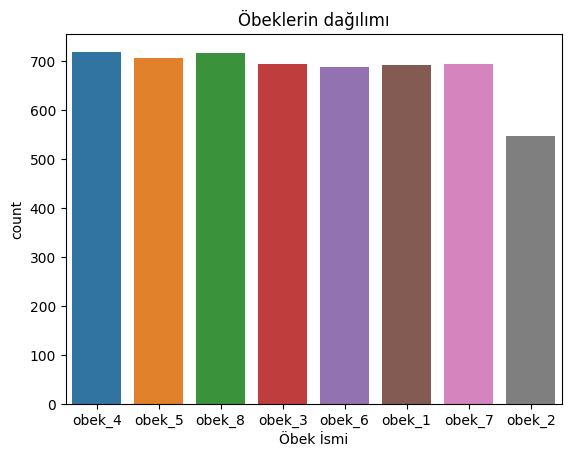

In [48]:
#Verideki öbek dağılımını inceleyelim.
sns.countplot(x='Öbek İsmi', data=train_df)
plt.title("Öbeklerin dağılımı")
plt.show()

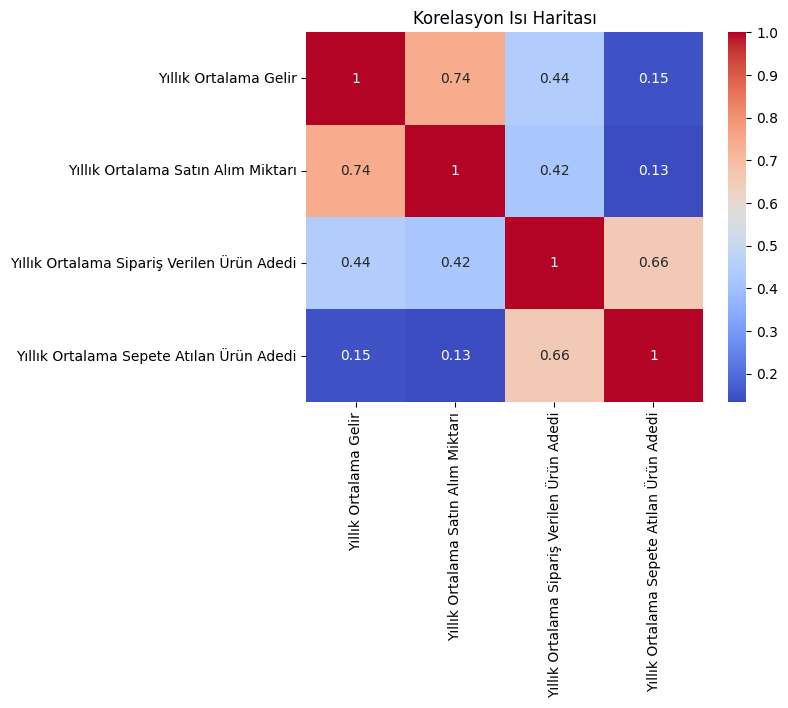

In [49]:
#Sayısal değer olan özelliklerin korelasyon ısı haritasını inceleyelim
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.title("Korelasyon Isı Haritası")
plt.show()


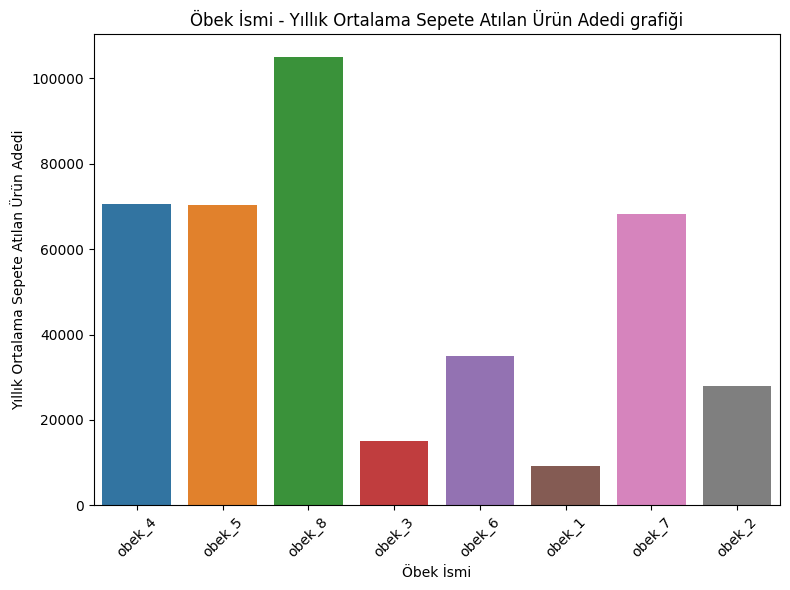

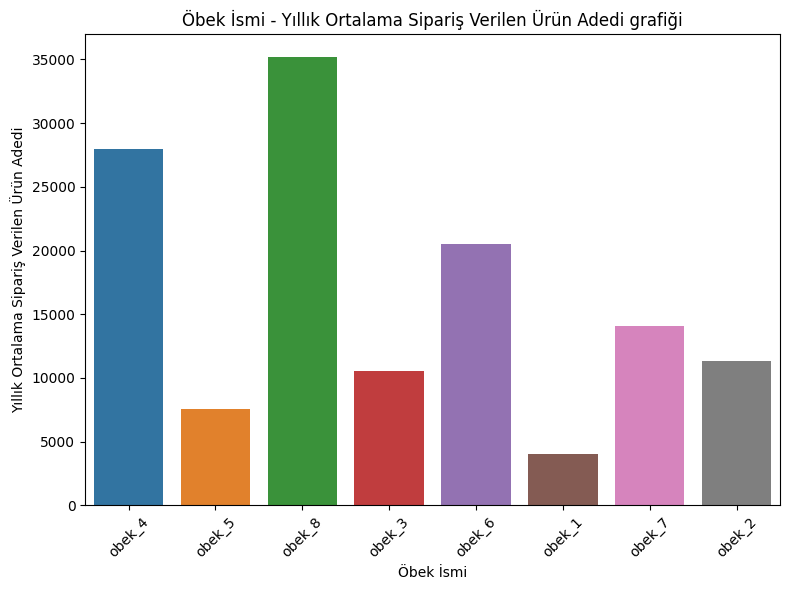

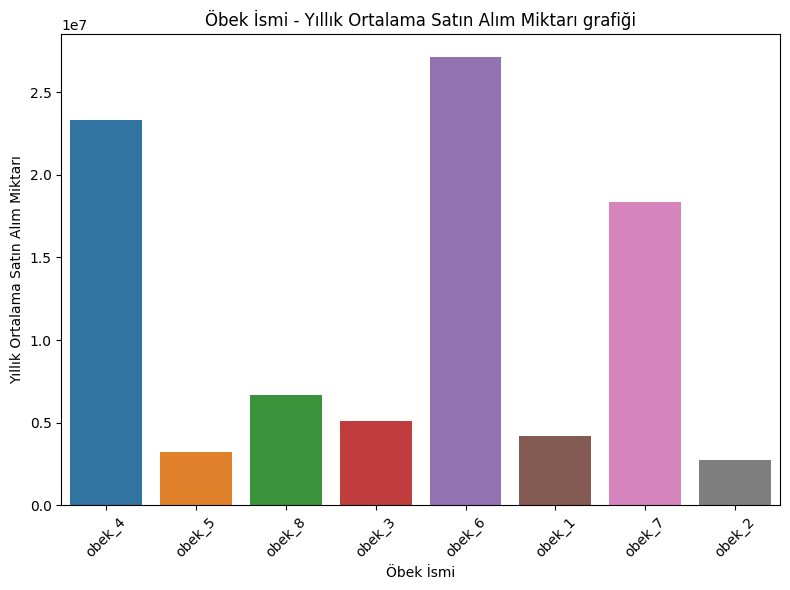

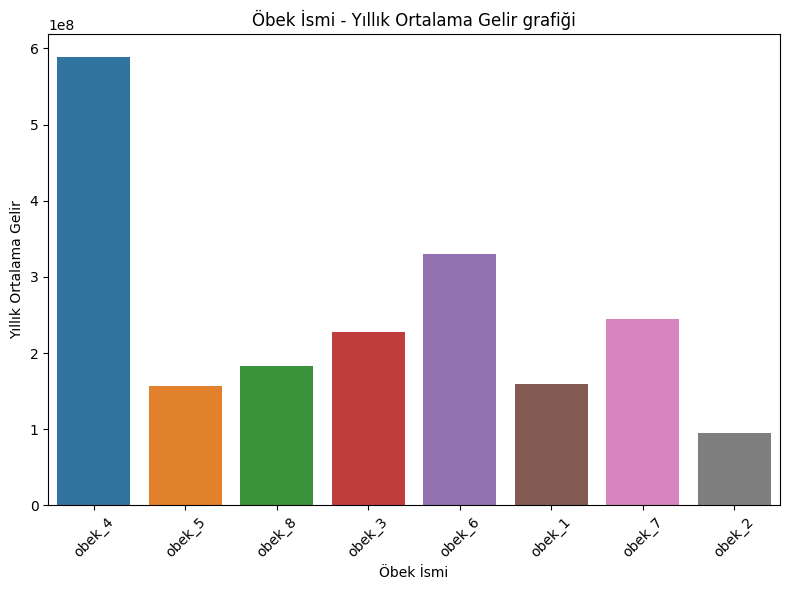

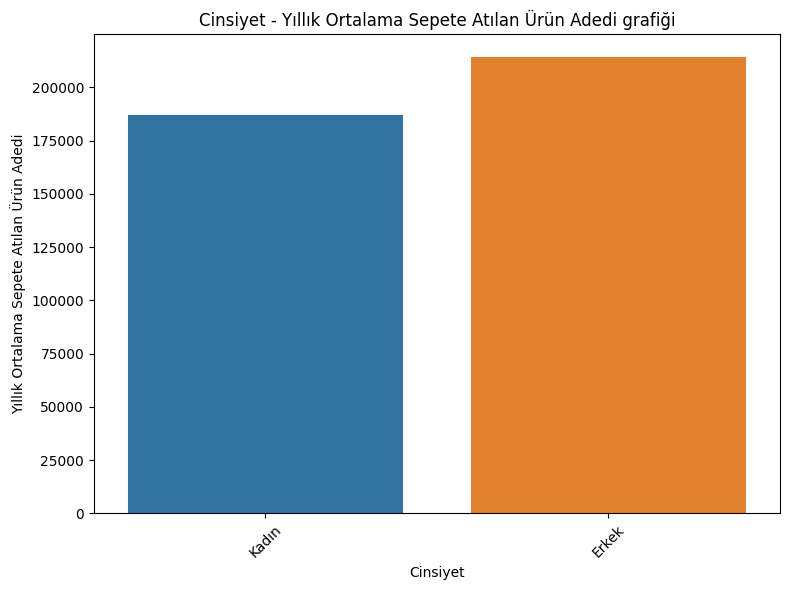

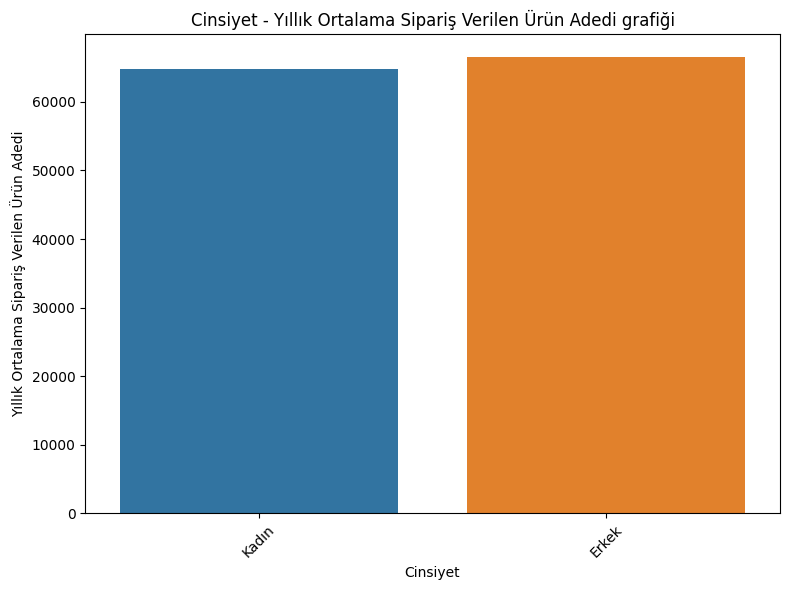

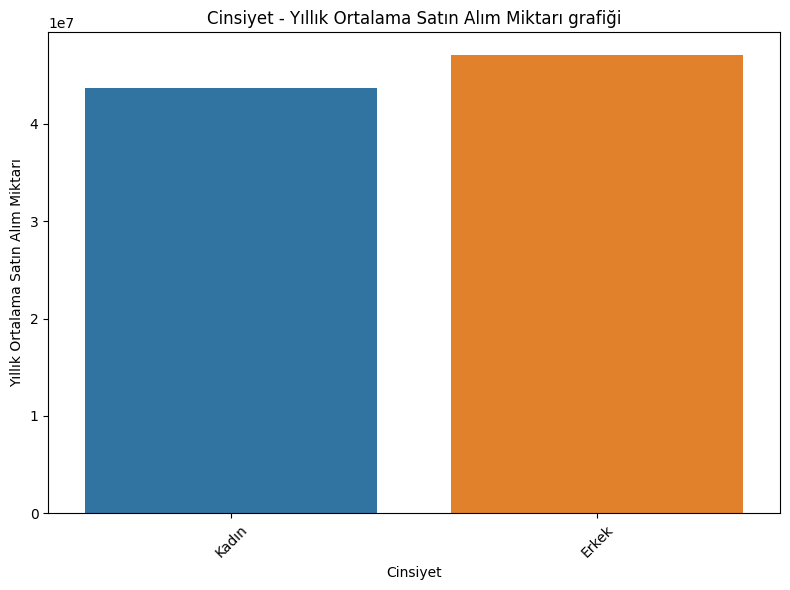

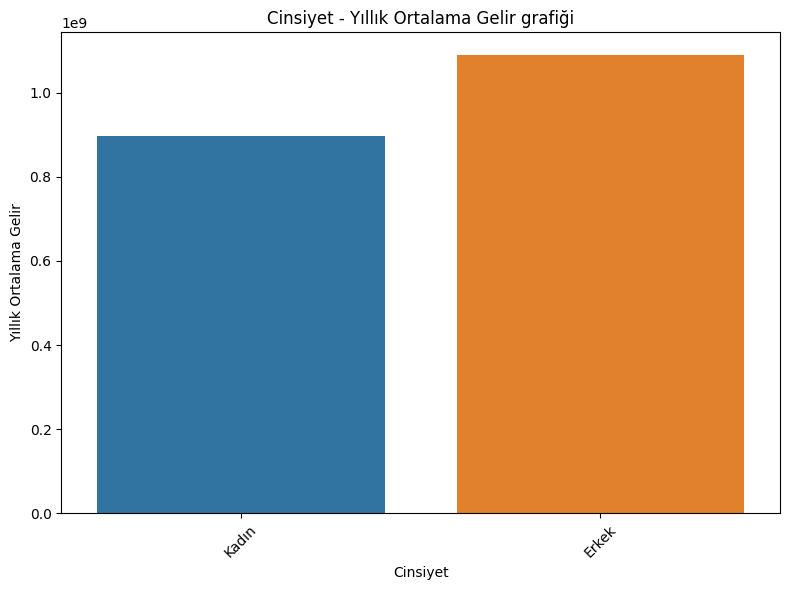

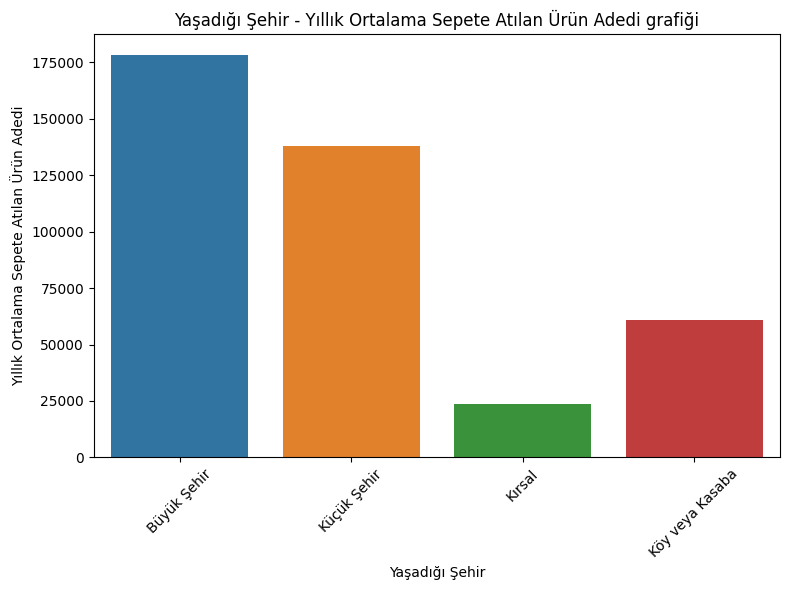

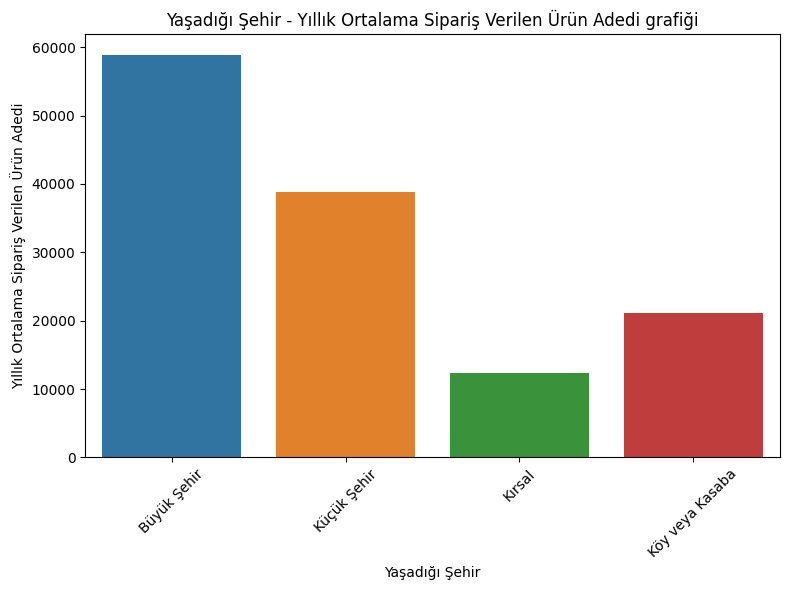

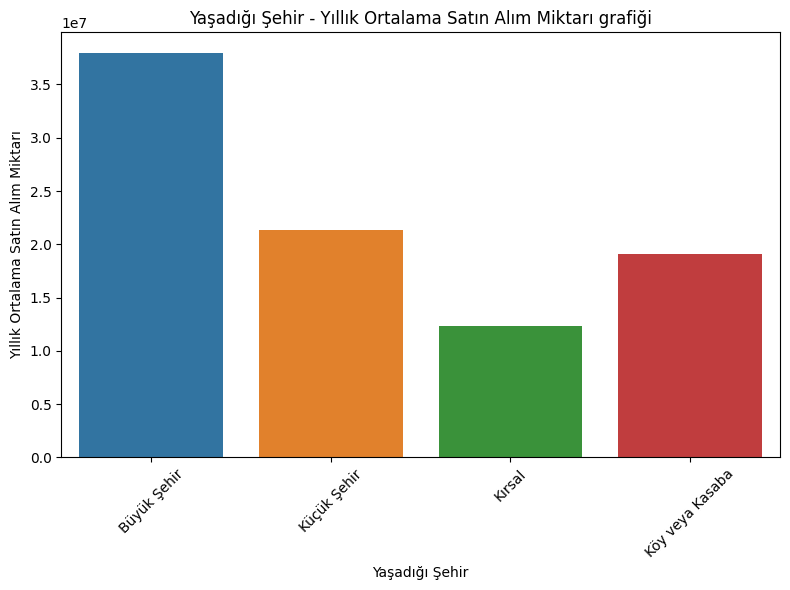

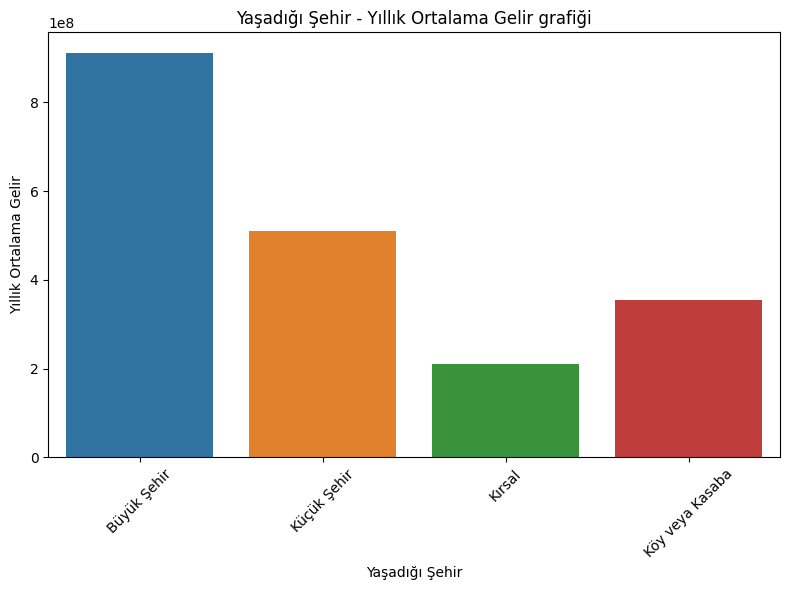

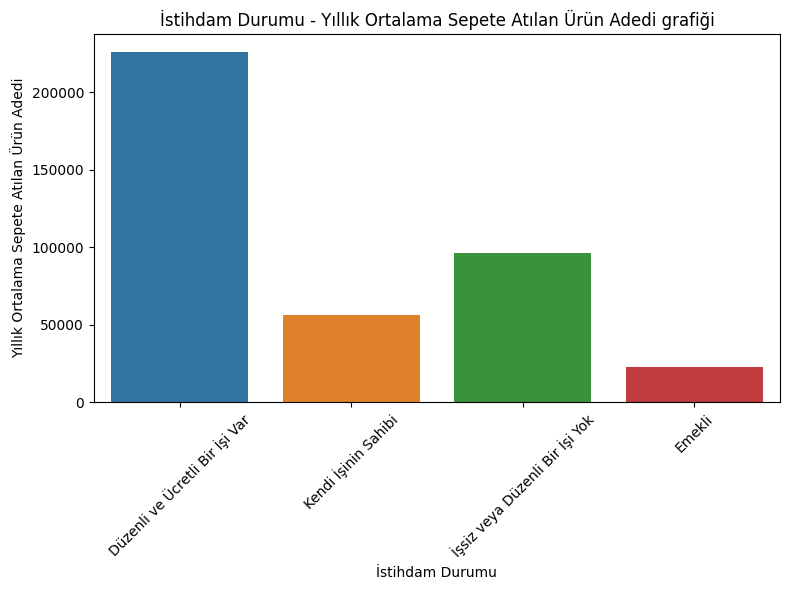

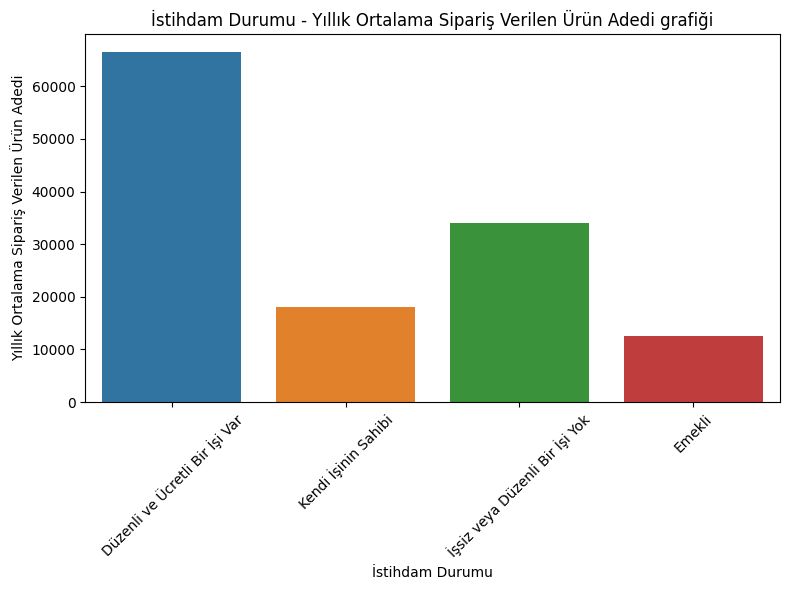

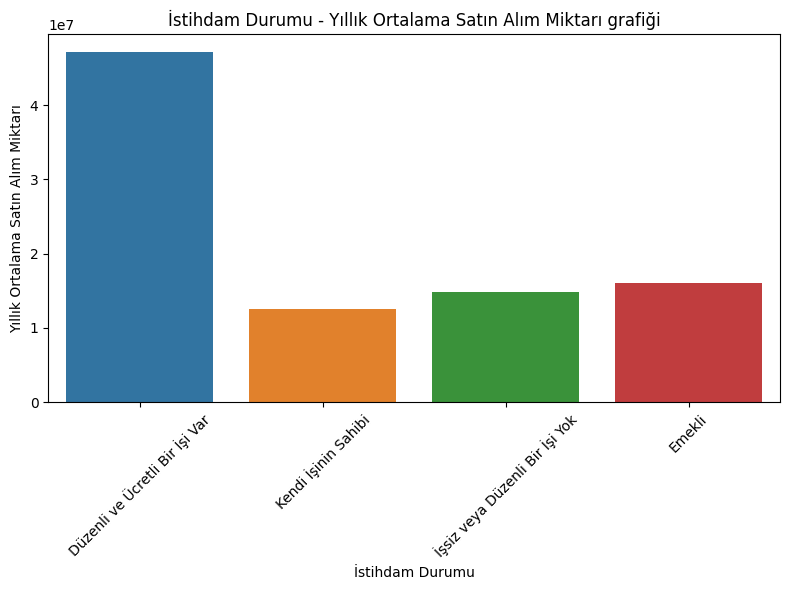

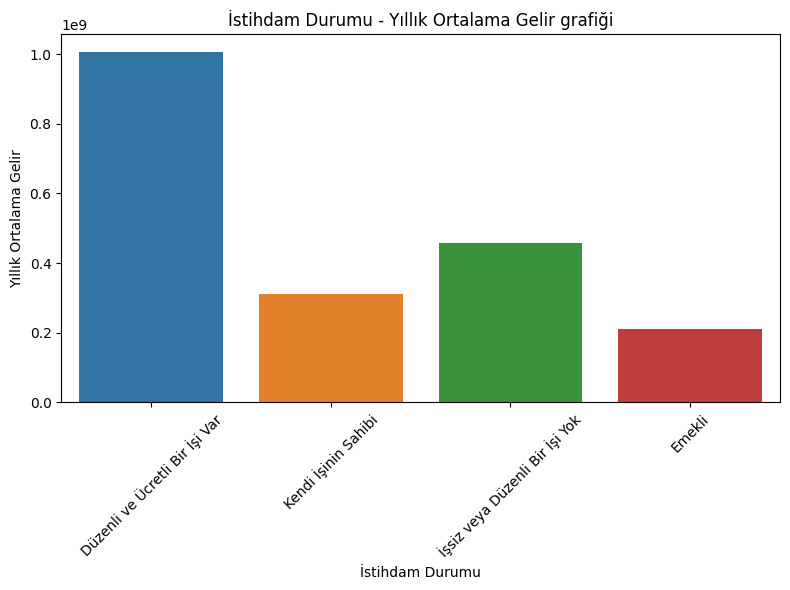

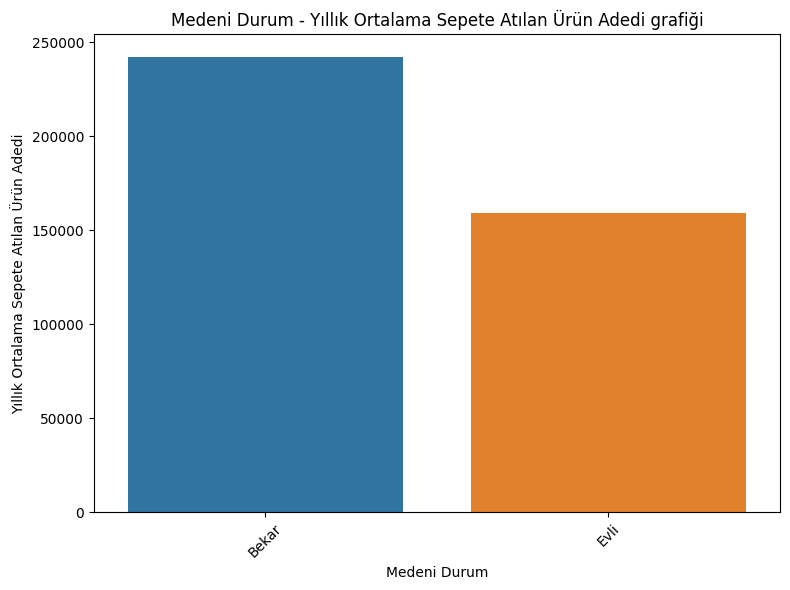

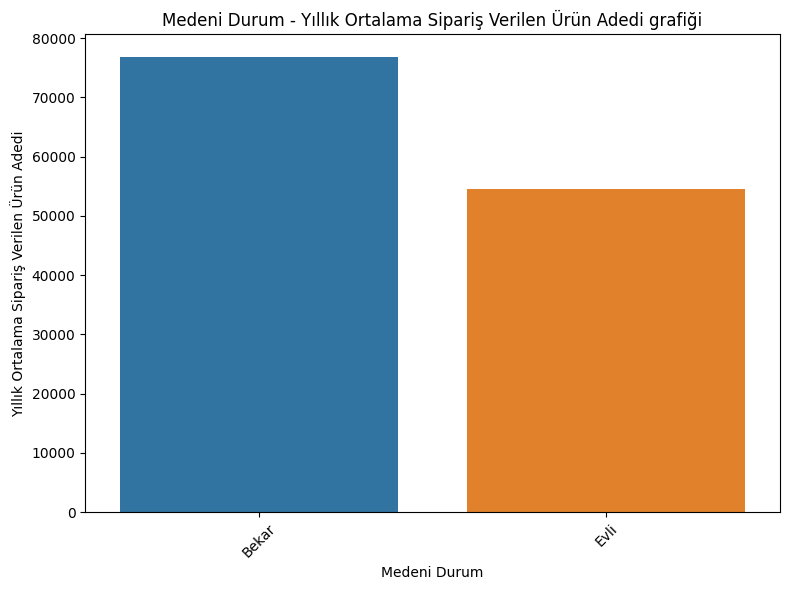

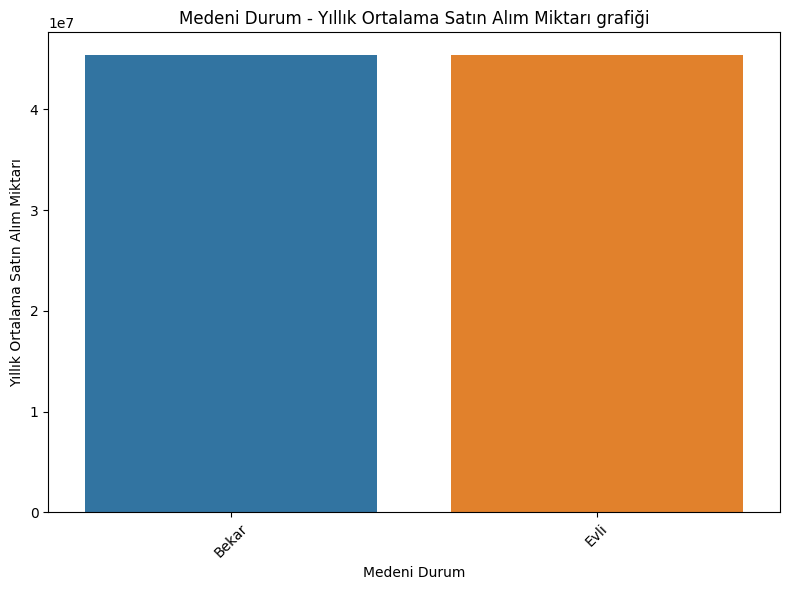

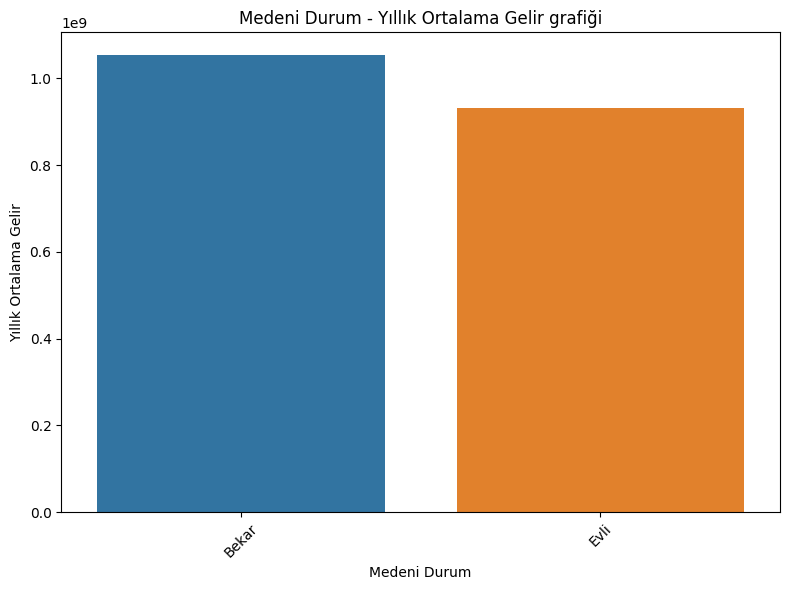

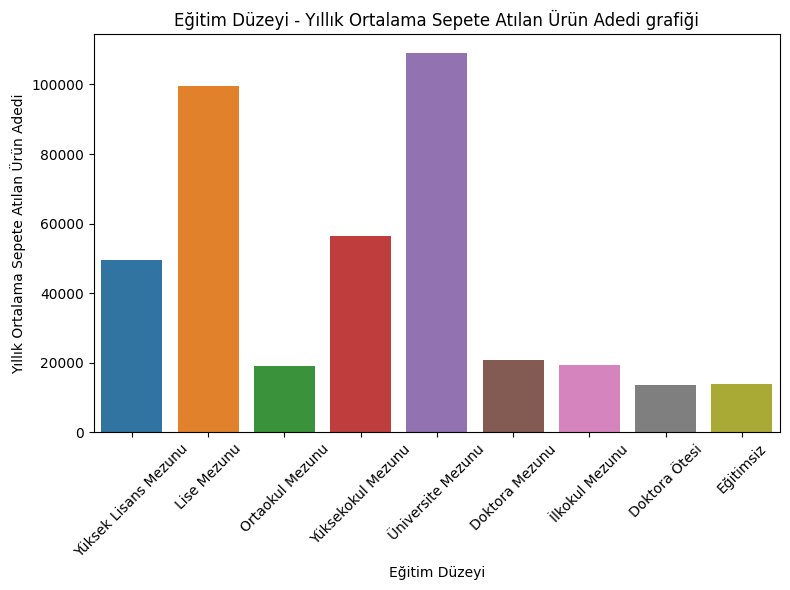

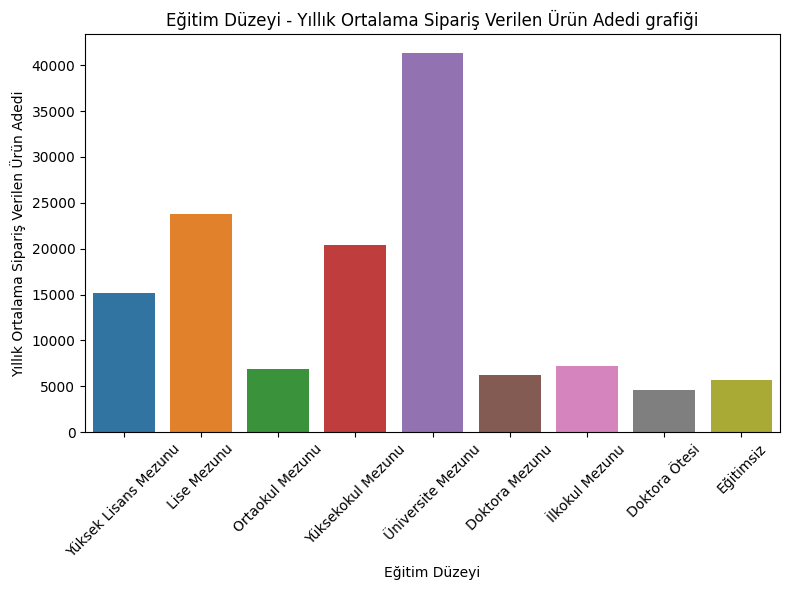

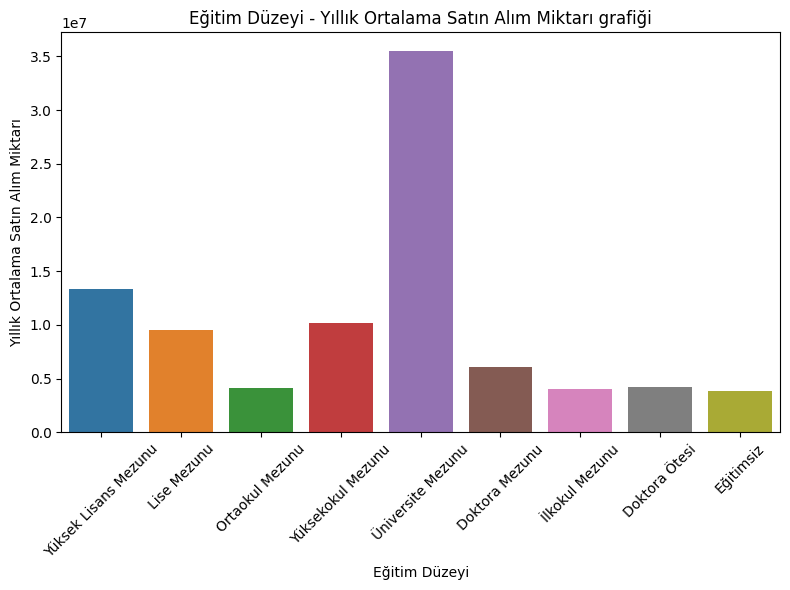

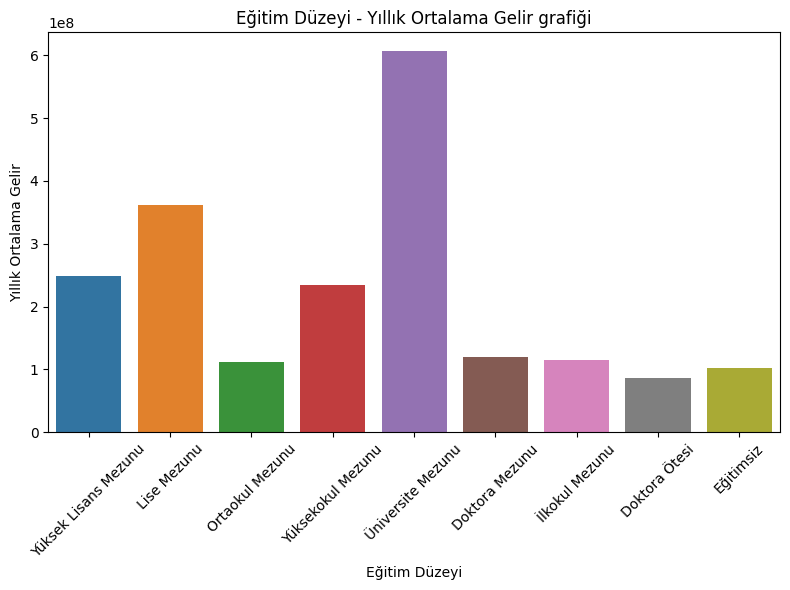

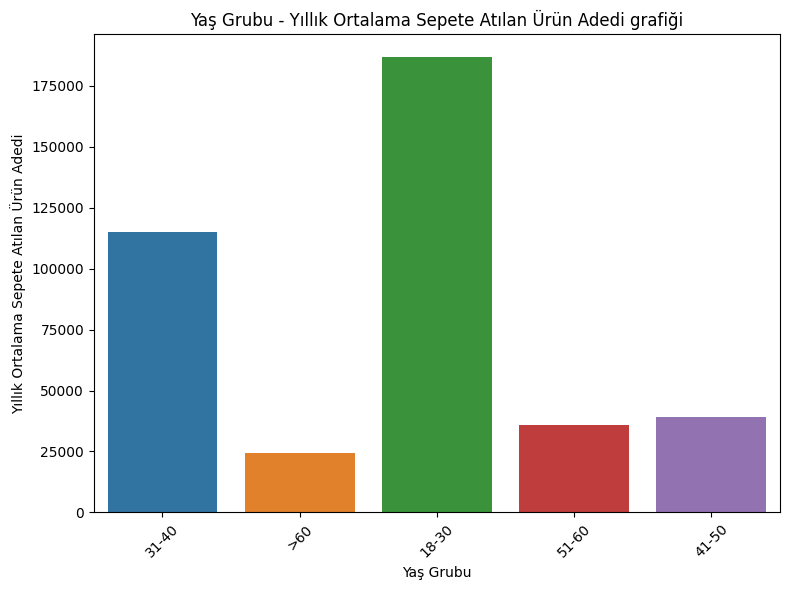

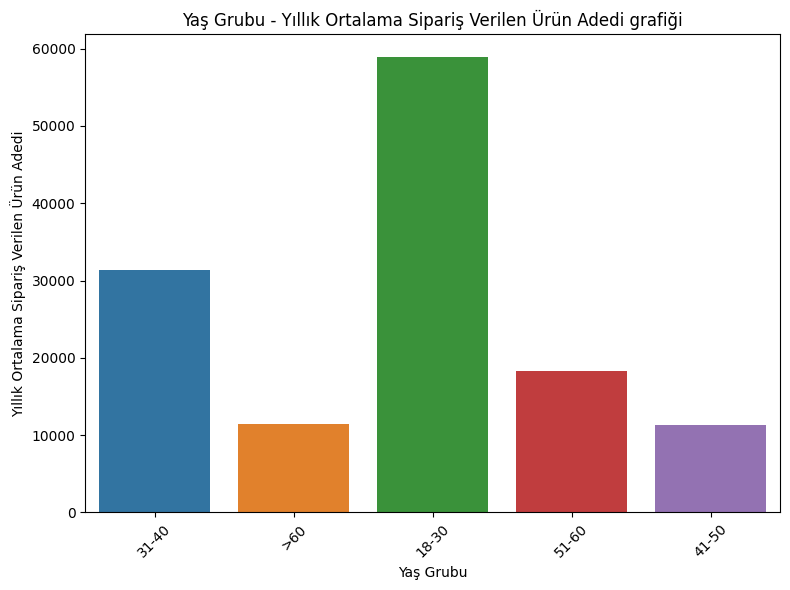

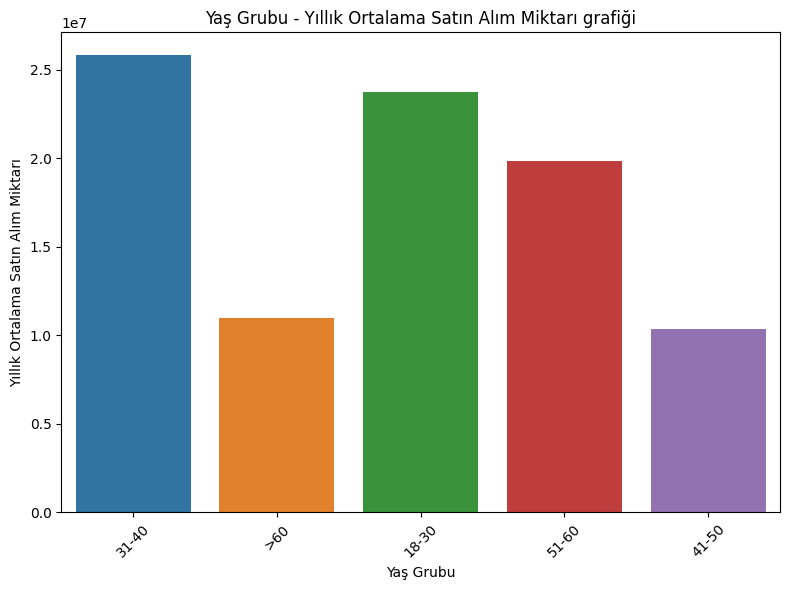

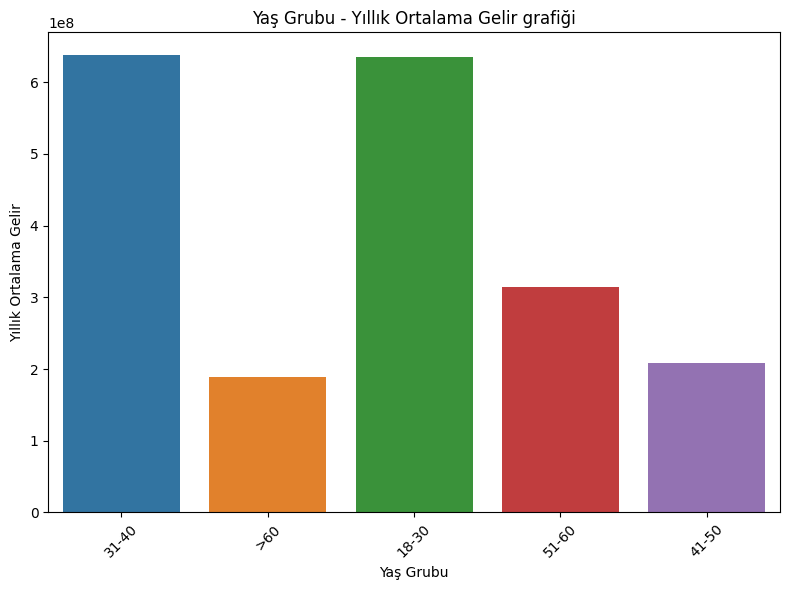

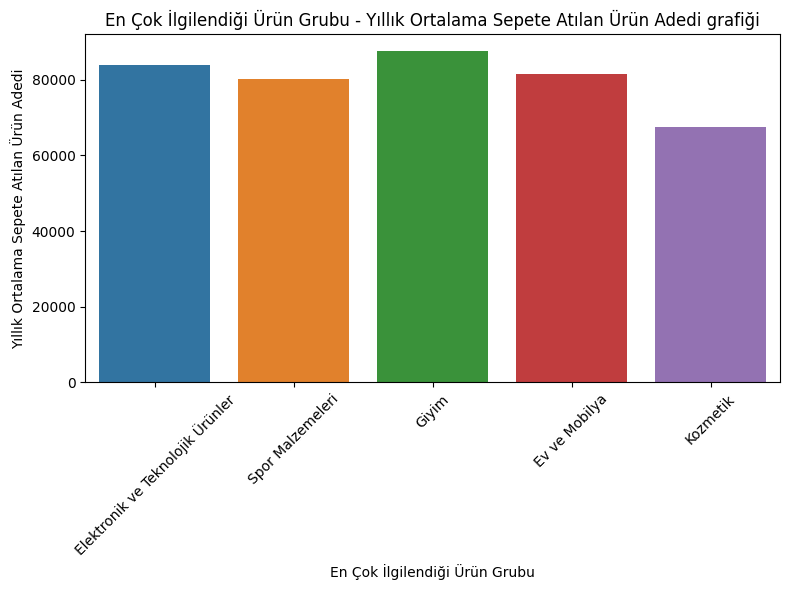

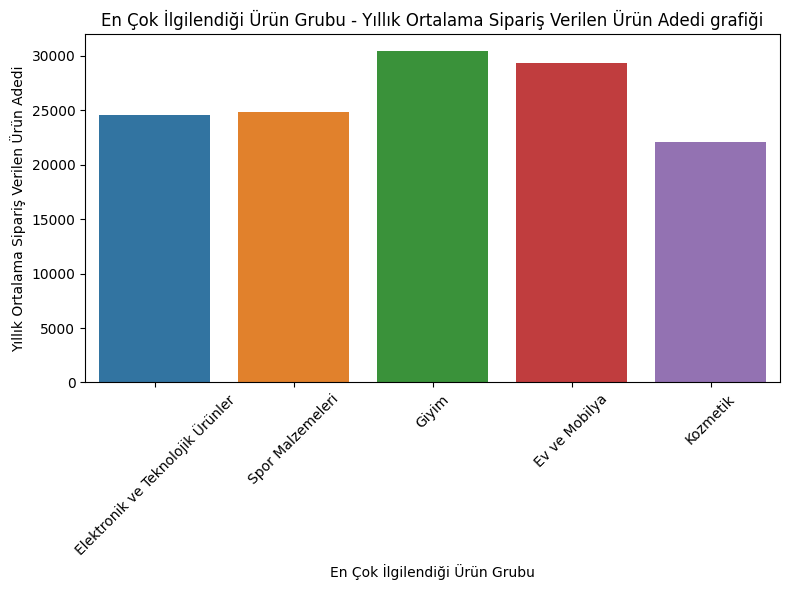

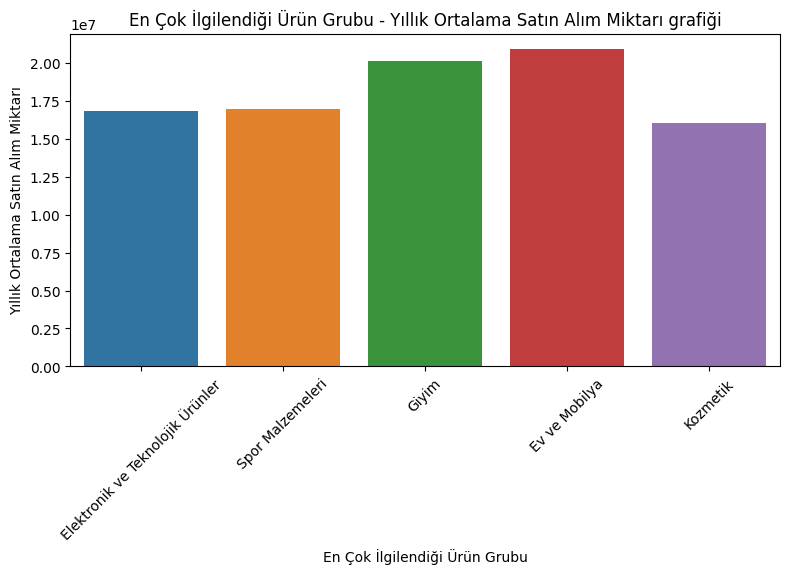

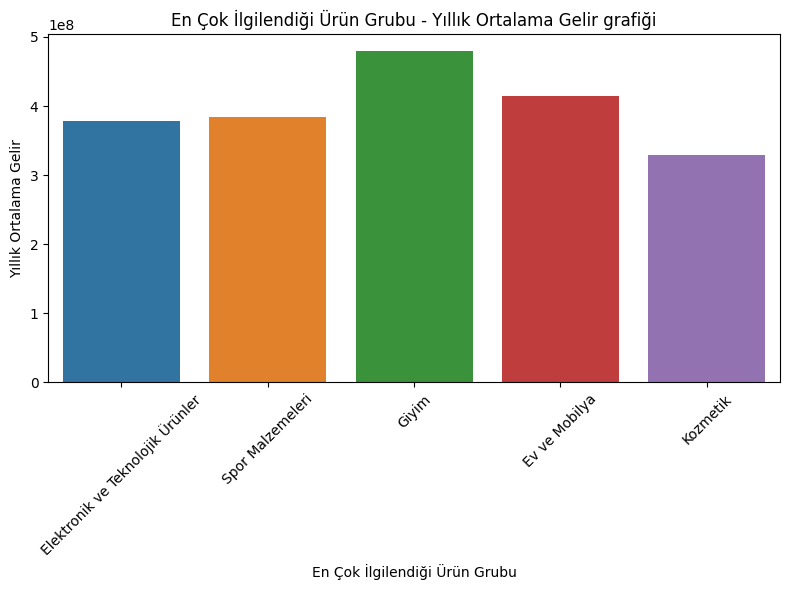

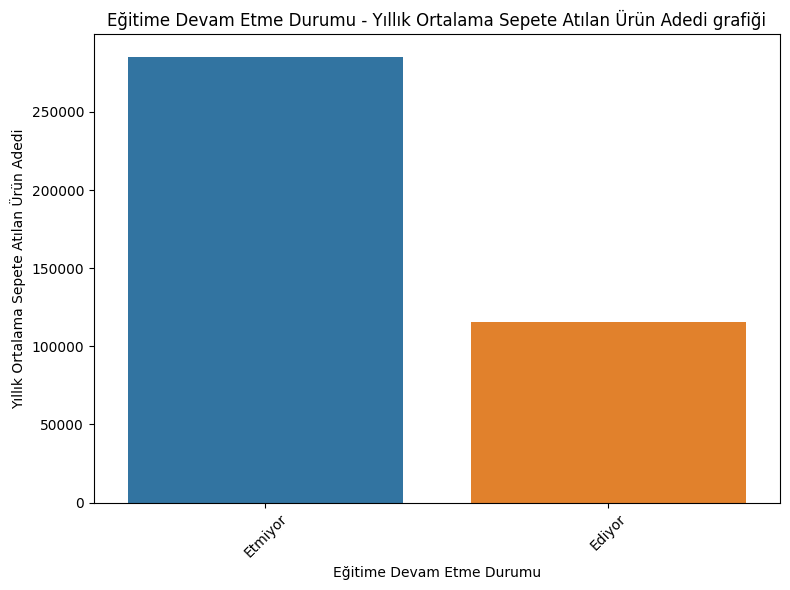

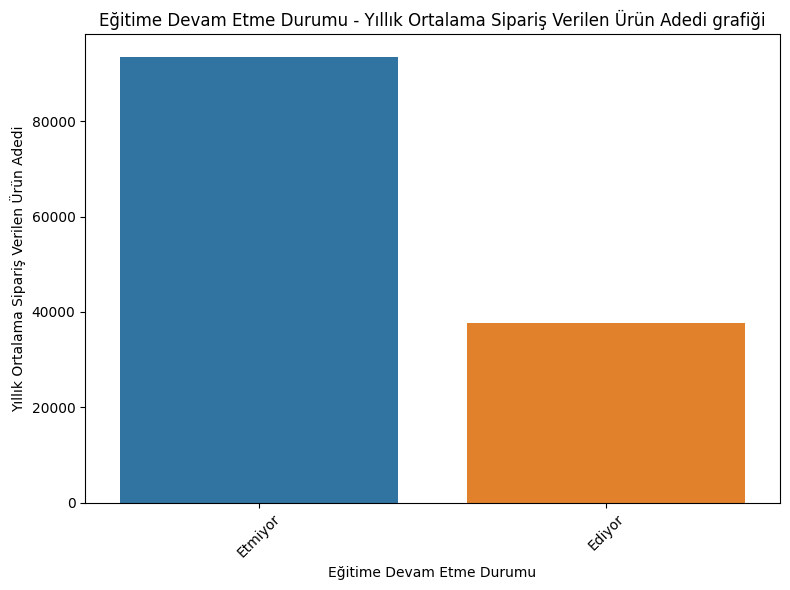

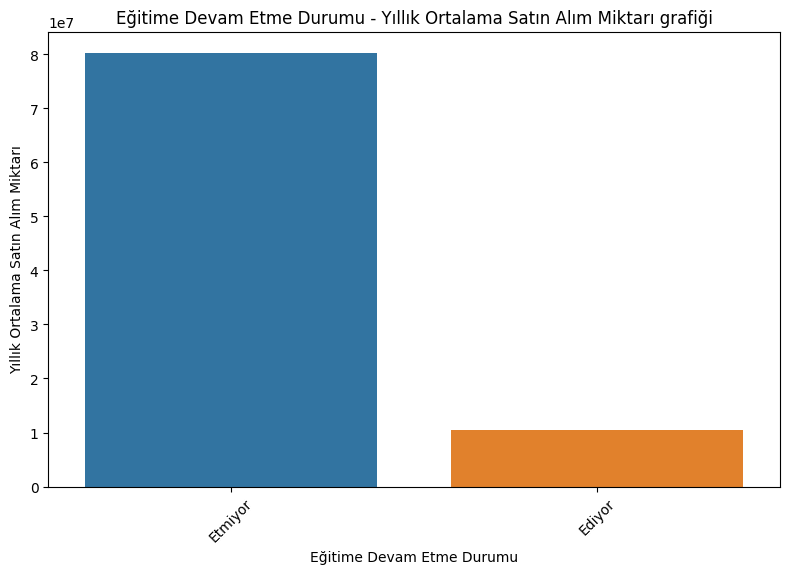

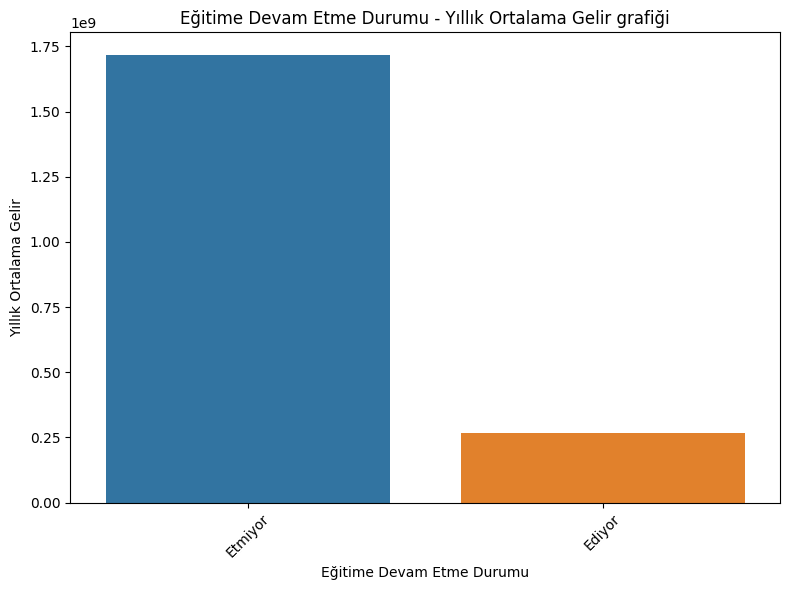

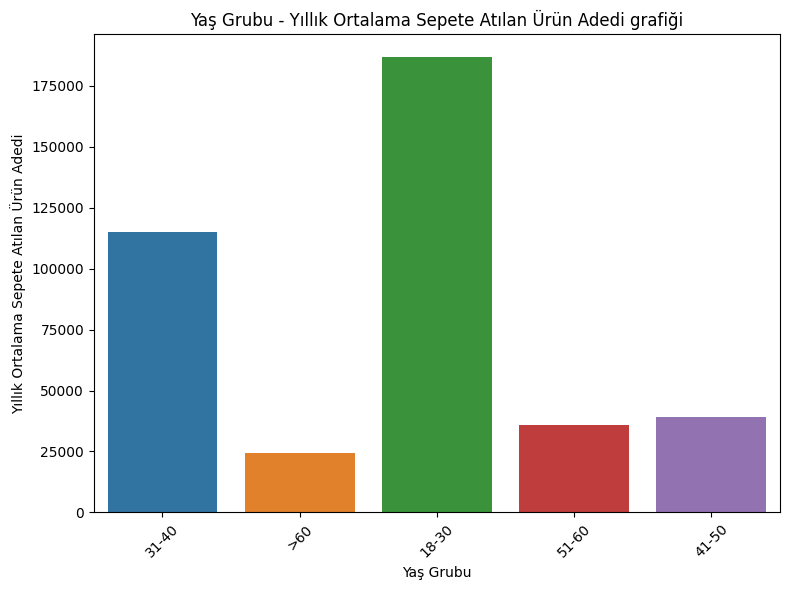

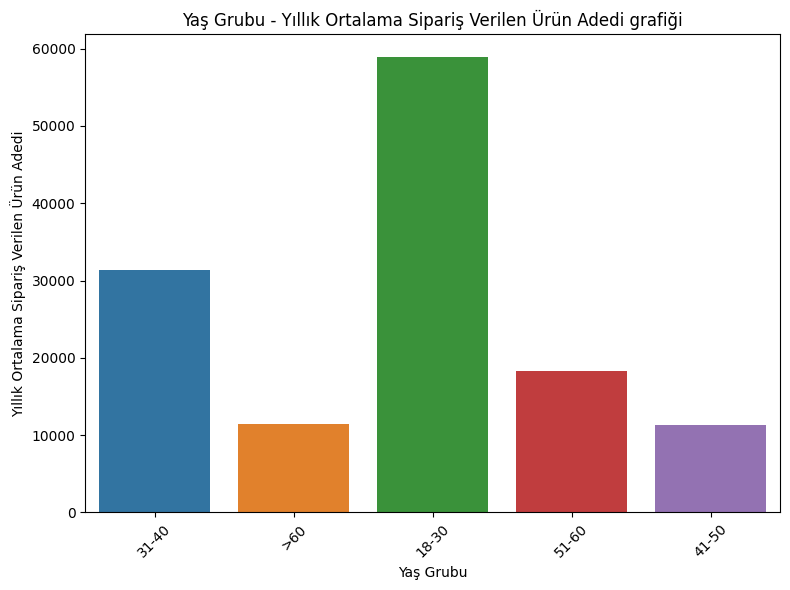

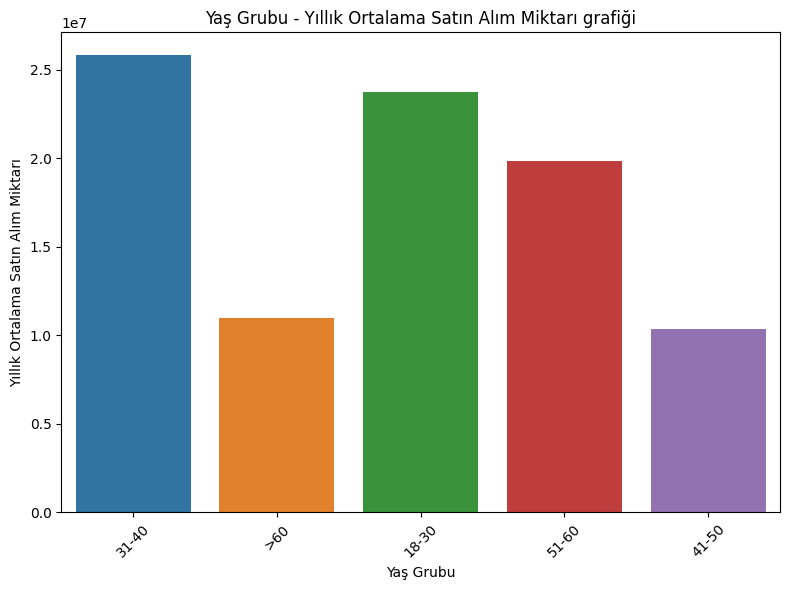

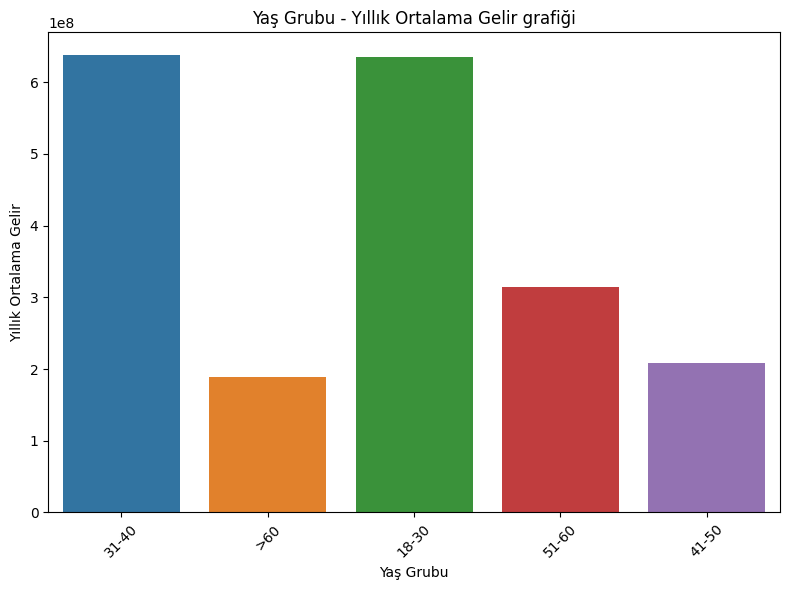

In [50]:
def sayisal_degiskenler_hedef_oge_karsilastirma():
  sayisal_degiskenler = ["Yıllık Ortalama Sepete Atılan Ürün Adedi","Yıllık Ortalama Sipariş Verilen Ürün Adedi","Yıllık Ortalama Satın Alım Miktarı","Yıllık Ortalama Gelir"]
  hedef_ogeler = ["Öbek İsmi","Cinsiyet","Yaşadığı Şehir","İstihdam Durumu","Medeni Durum","Eğitim Düzeyi","Yaş Grubu","En Çok İlgilendiği Ürün Grubu","Eğitime Devam Etme Durumu","Yaş Grubu"]
  for hedef_oge in hedef_ogeler:
    for sayisal_degisken in sayisal_degiskenler:
      plt.figure(figsize=(8, 6))
      sns.barplot(x=hedef_oge, y=sayisal_degisken, data=train_df, estimator=sum, errorbar=None)
      plt.title(f"{hedef_oge} - {sayisal_degisken} grafiği")
      plt.xlabel(hedef_oge)
      plt.ylabel(sayisal_degisken)
      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()
# Bu kod ile kategorik değişkenlerimiz ile sayısal değişkenlerimiz arasındaki ilişkiyi görselleştiren bir fonksiyon oluşturmuş olduk.
# Fonksiyonu çağırarak incelemeler yapılabilir.
sayisal_degiskenler_hedef_oge_karsilastirma()

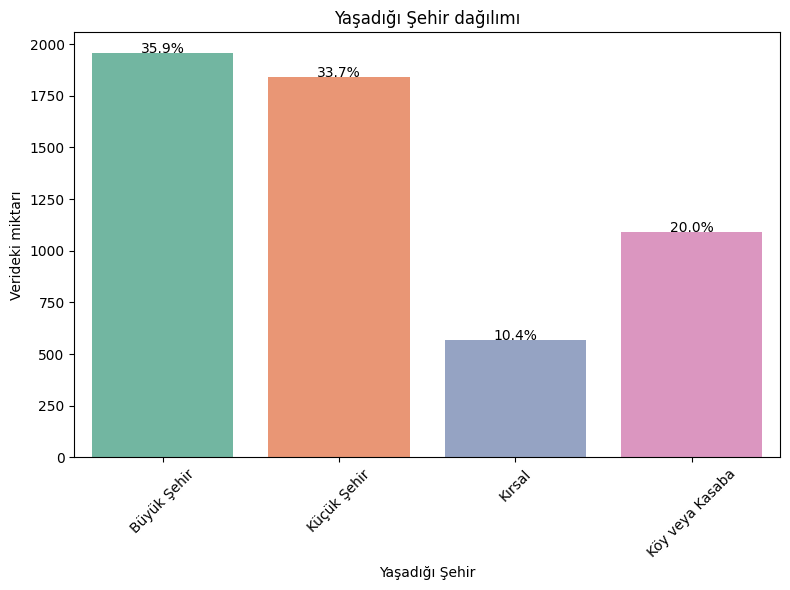

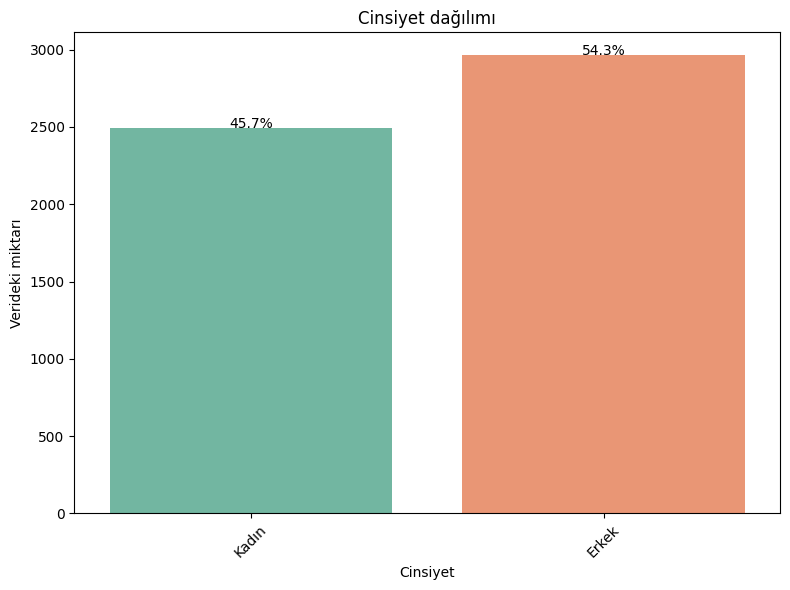

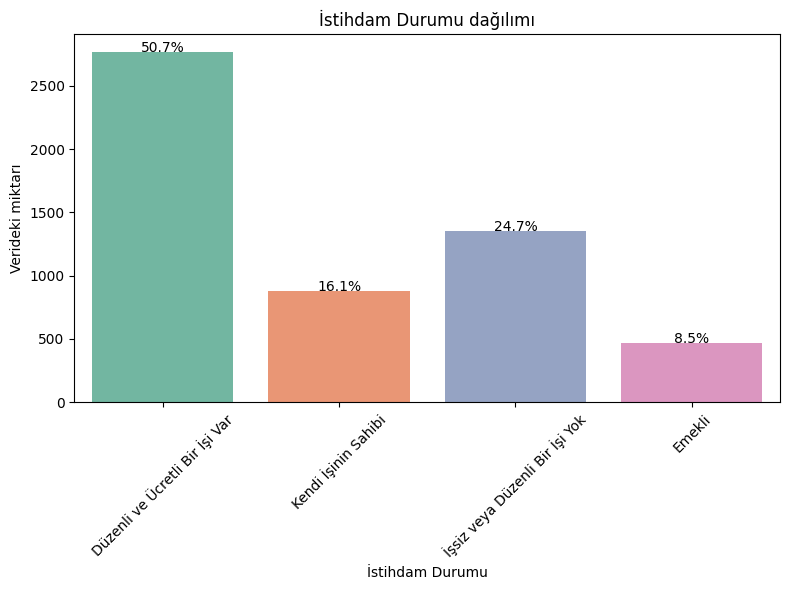

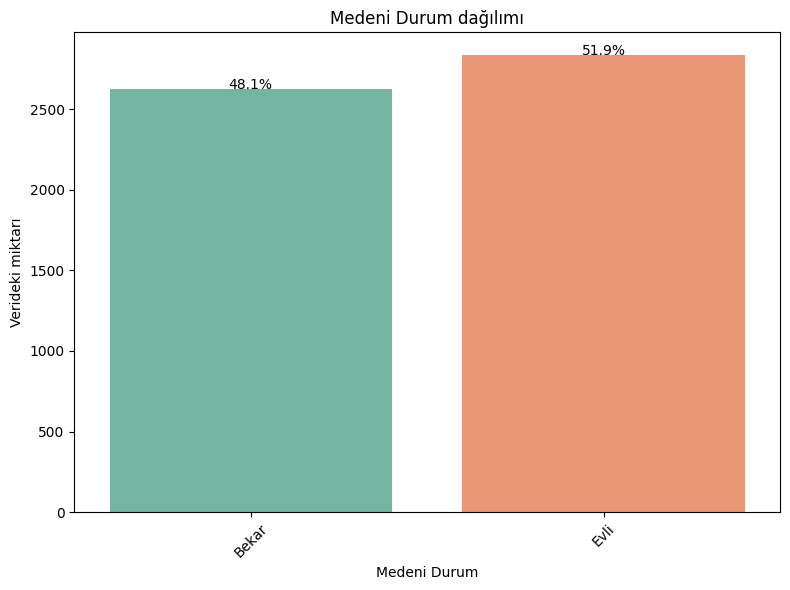

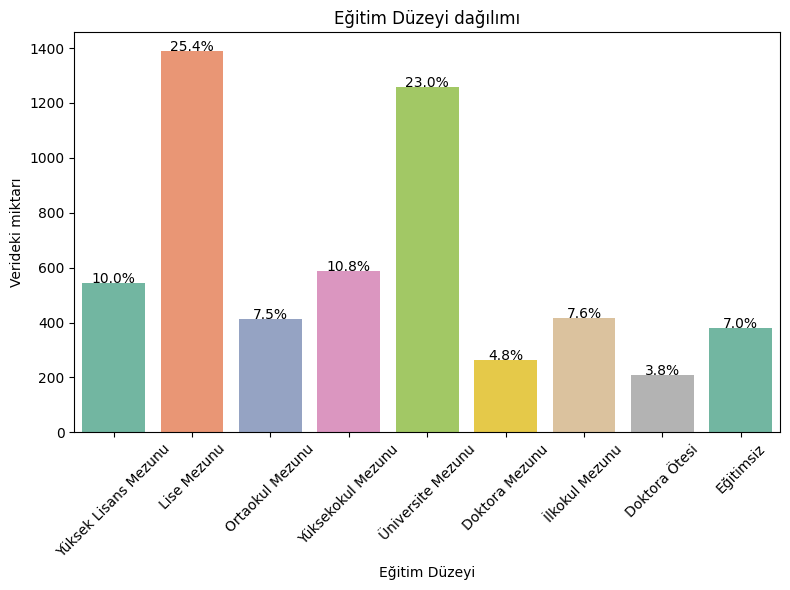

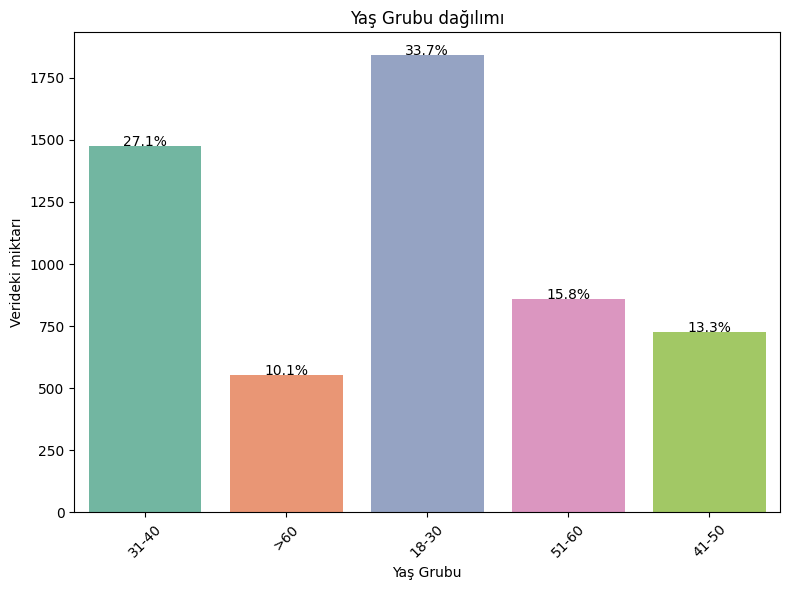

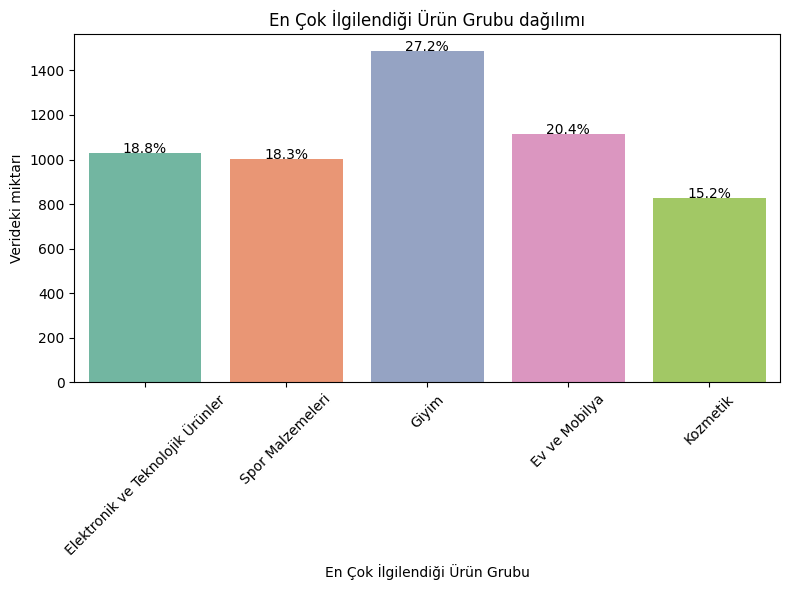

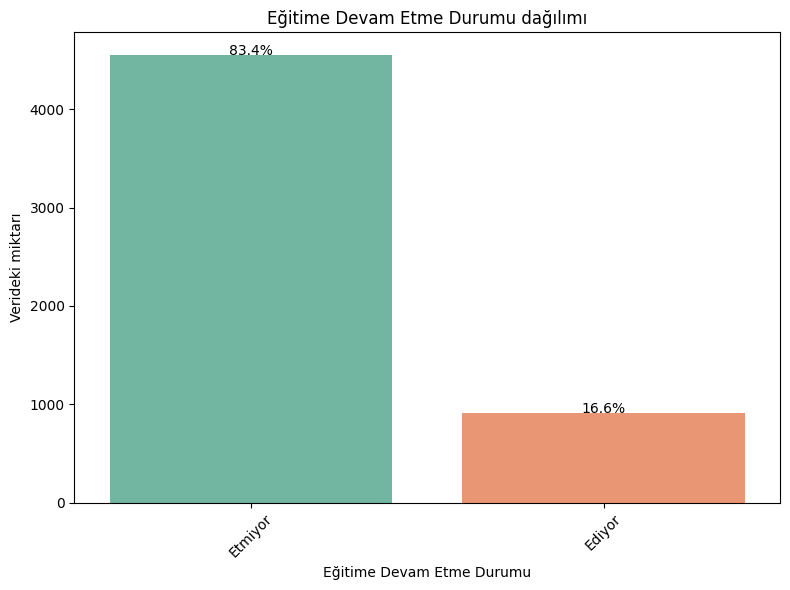

In [51]:
def kategorik_degiskenlerin_dagilimi():
    kategorik_degiskenler = ["Yaşadığı Şehir", "Cinsiyet", "İstihdam Durumu", "Medeni Durum", "Eğitim Düzeyi",
                             "Yaş Grubu", "En Çok İlgilendiği Ürün Grubu", "Eğitime Devam Etme Durumu"]

    for kategorik_degisken in kategorik_degiskenler:
        plt.figure(figsize=(8, 6))
        ax = sns.countplot(x=kategorik_degisken, data=train_df, palette="Set2")
        plt.title(f"{kategorik_degisken} dağılımı")
        plt.xlabel(kategorik_degisken)
        plt.ylabel("Verideki miktarı")
        plt.xticks(rotation=45)

        total = len(train_df[kategorik_degisken])
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha="center")

        plt.tight_layout()
plt.show()
kategorik_degiskenlerin_dagilimi()

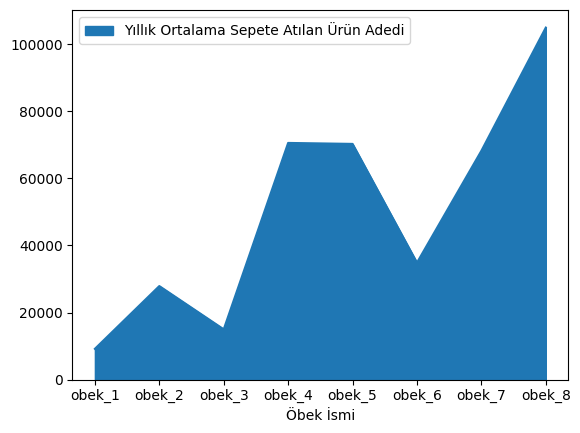

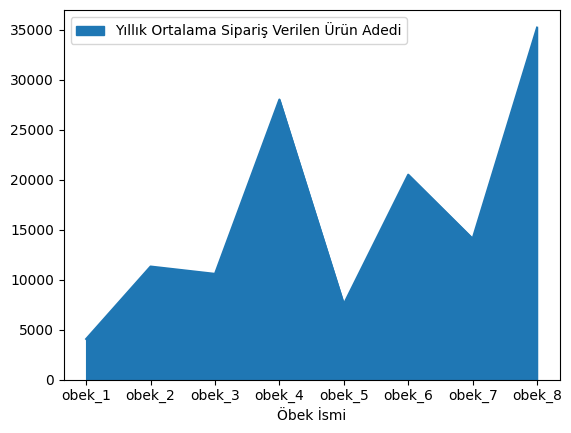

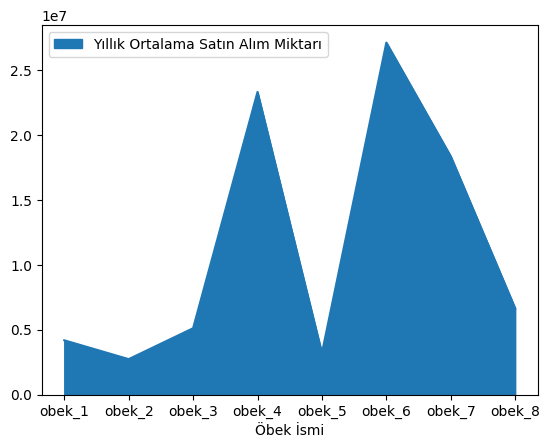

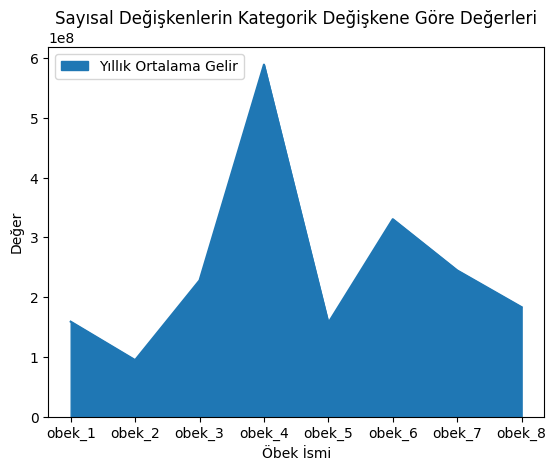

In [52]:
#Öbeklere göre sayısal değişkenleri farklı grafiklerle inceleyelim
sayisal_degiskenler = [
    'Yıllık Ortalama Sepete Atılan Ürün Adedi',
    'Yıllık Ortalama Sipariş Verilen Ürün Adedi',
    'Yıllık Ortalama Satın Alım Miktarı',
    'Yıllık Ortalama Gelir'
]


for sayisal_degisken in sayisal_degiskenler:
    stacked_data = train_df.pivot_table(index='Öbek İsmi', values=sayisal_degisken, aggfunc='sum')
    stacked_data.plot(kind='area', stacked=True)


plt.title('Sayısal Değişkenlerin Kategorik Değişkene Göre Değerleri')
plt.xlabel('Öbek İsmi')
plt.ylabel('Değer')
plt.legend(loc='upper left')

plt.show()

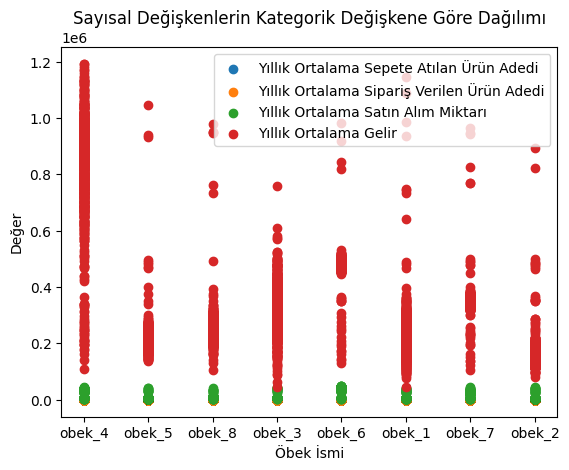

In [53]:
sayisal_degiskenler = [
    'Yıllık Ortalama Sepete Atılan Ürün Adedi',
    'Yıllık Ortalama Sipariş Verilen Ürün Adedi',
    'Yıllık Ortalama Satın Alım Miktarı',
    'Yıllık Ortalama Gelir'
]


for sayisal_degisken in sayisal_degiskenler:
    plt.scatter(train_df['Öbek İsmi'], train_df[sayisal_degisken], label=sayisal_degisken)

plt.title('Sayısal Değişkenlerin Kategorik Değişkene Göre Dağılımı')
plt.xlabel('Öbek İsmi')
plt.ylabel('Değer')
plt.legend(loc='upper right')

plt.show()

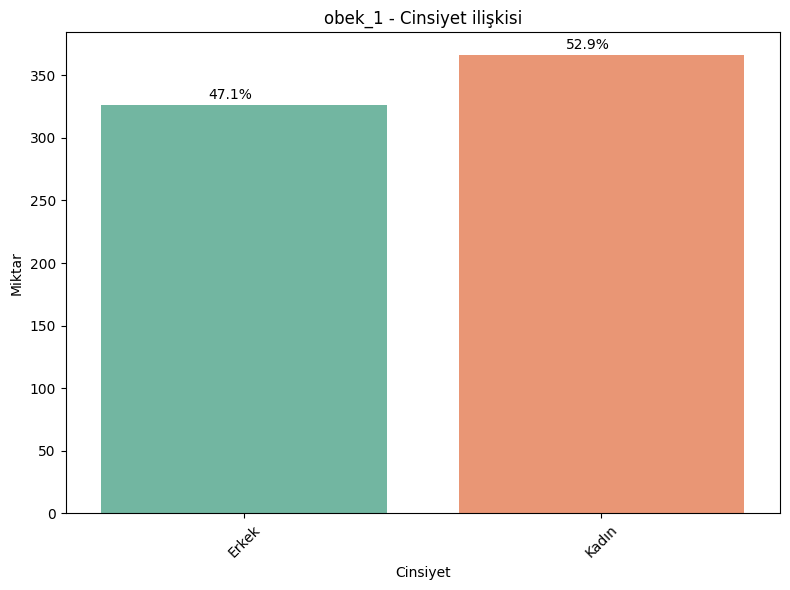

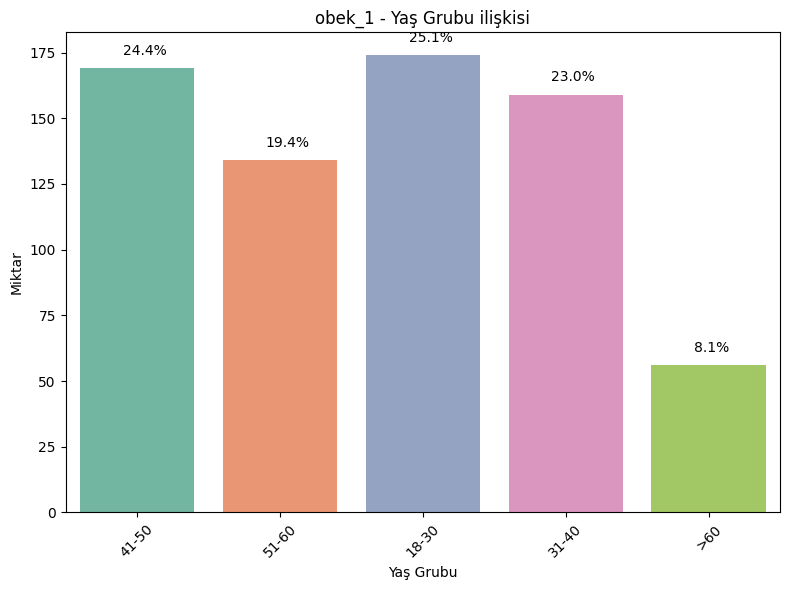

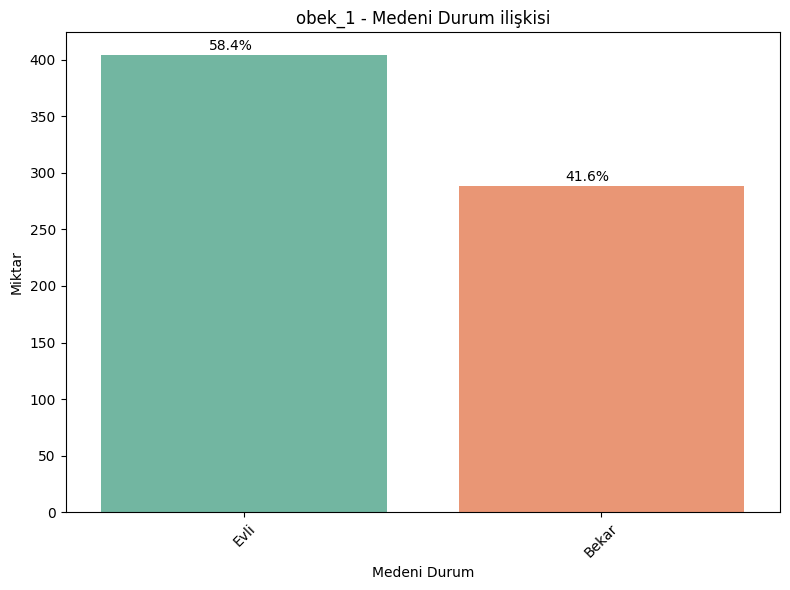

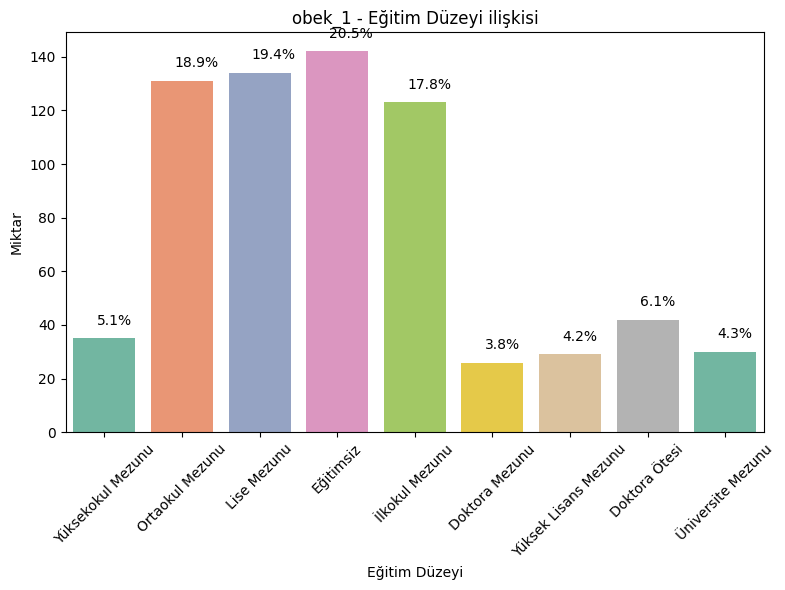

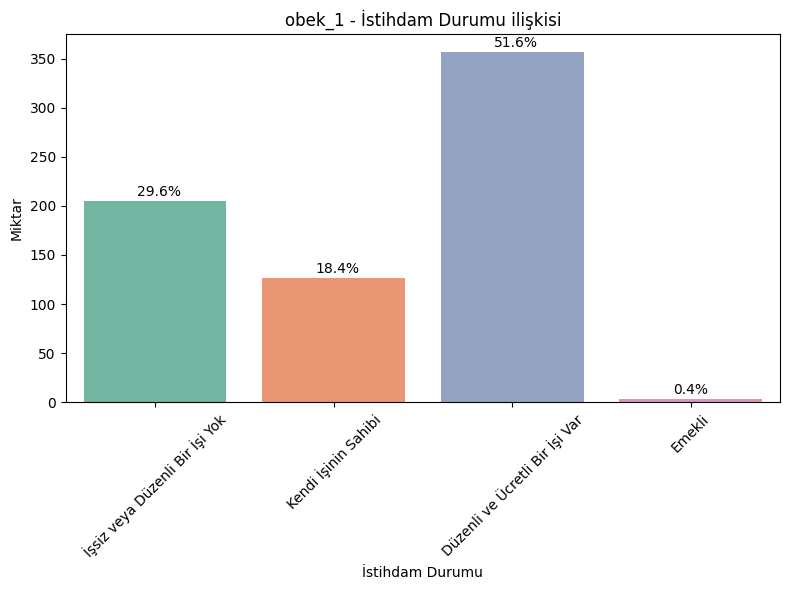

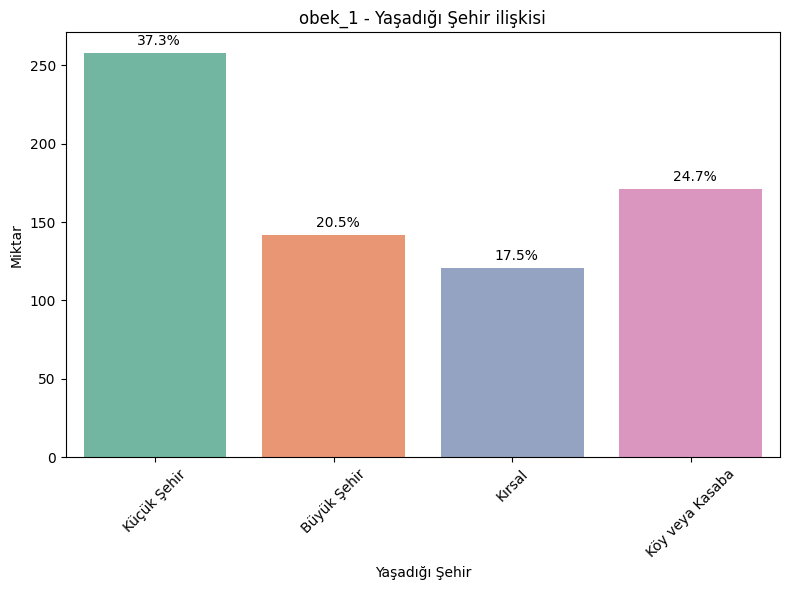

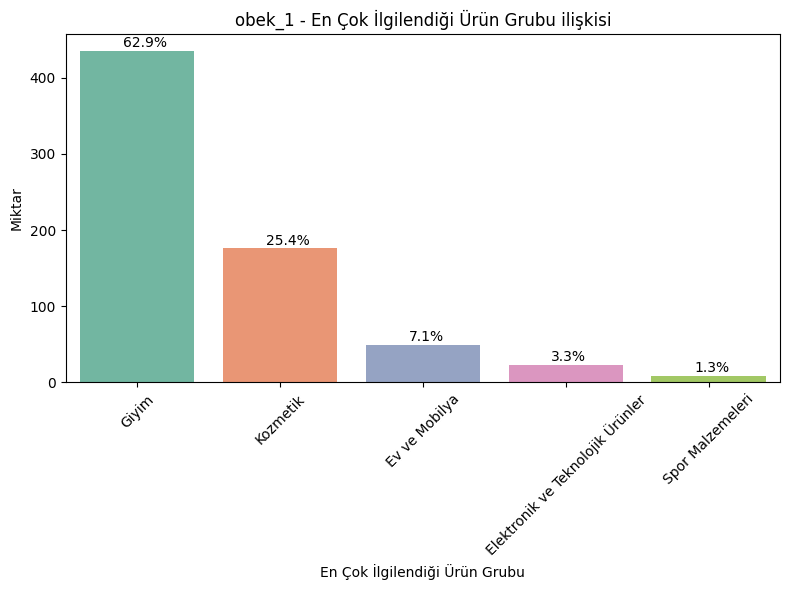

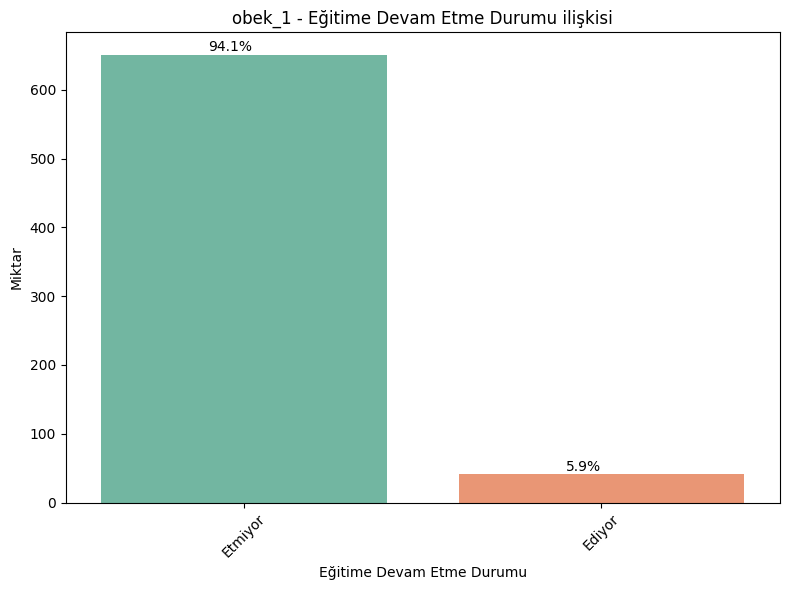

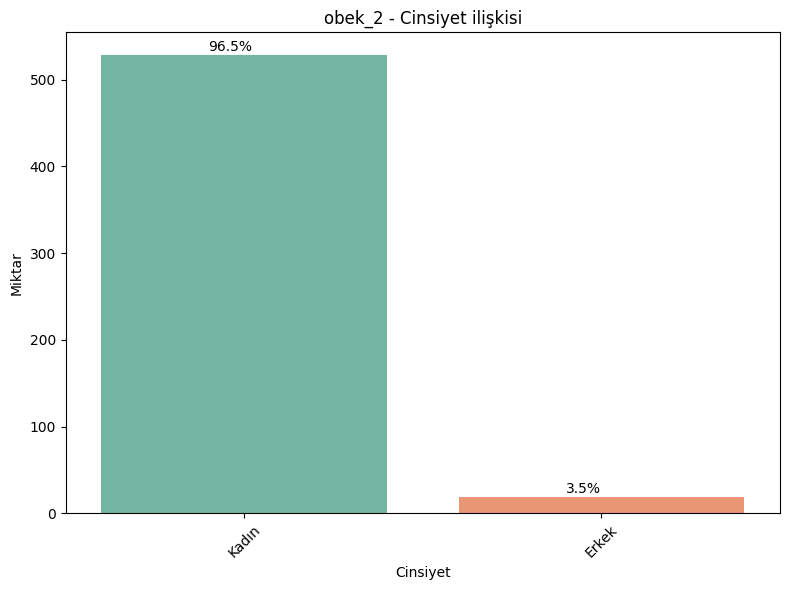

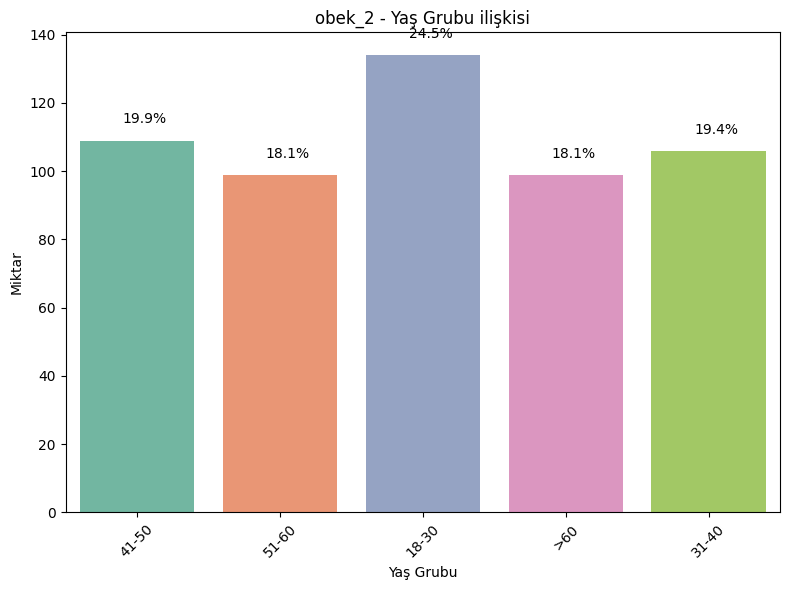

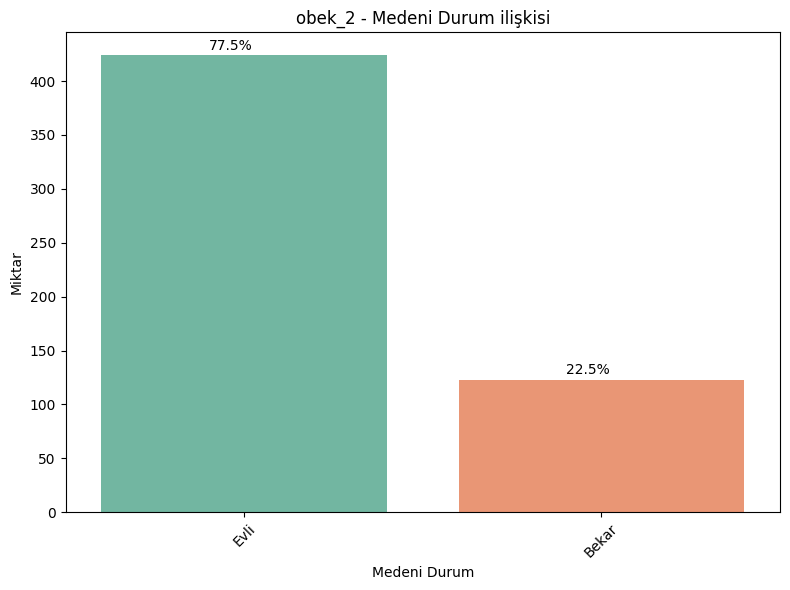

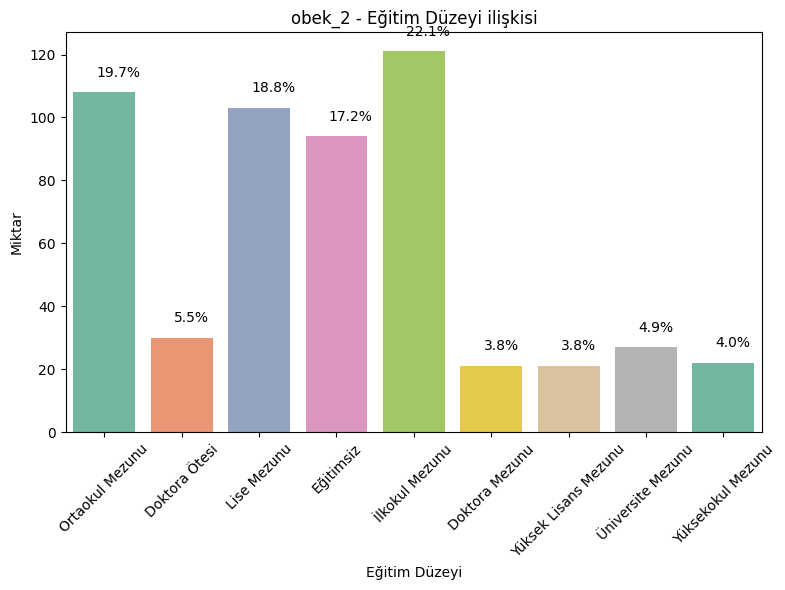

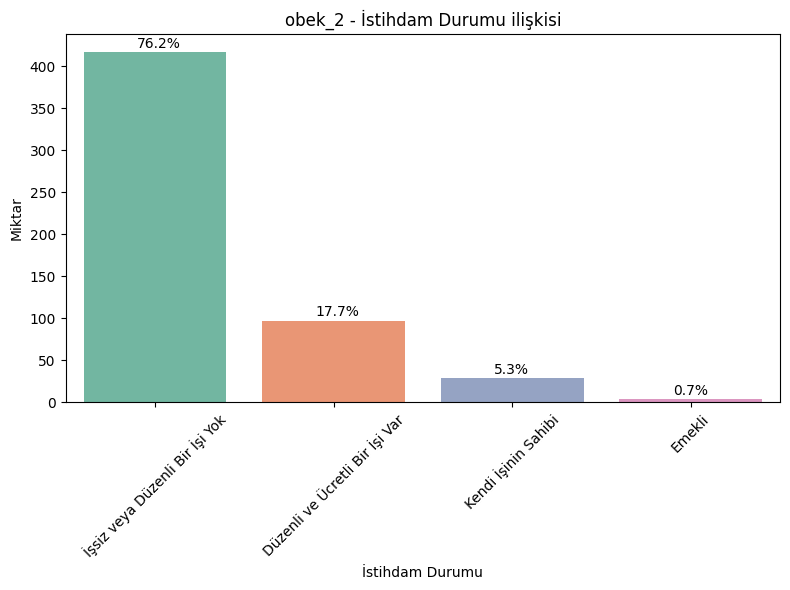

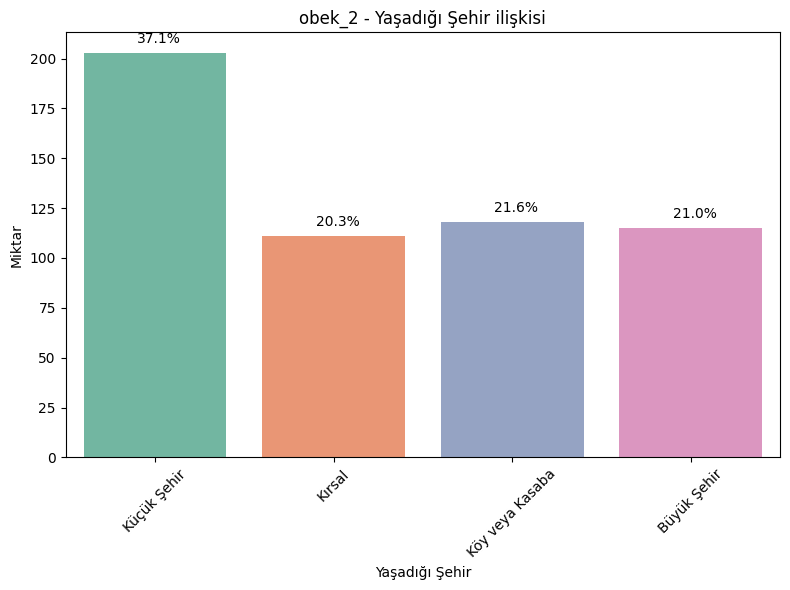

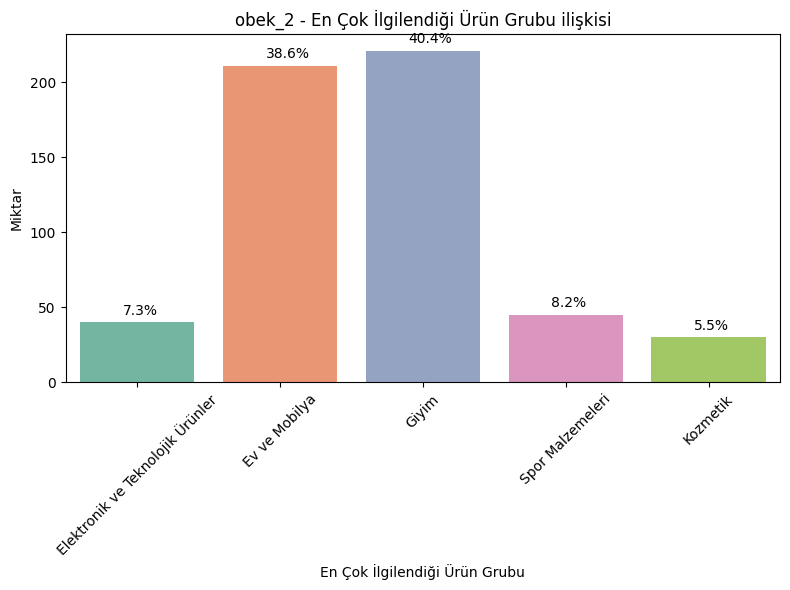

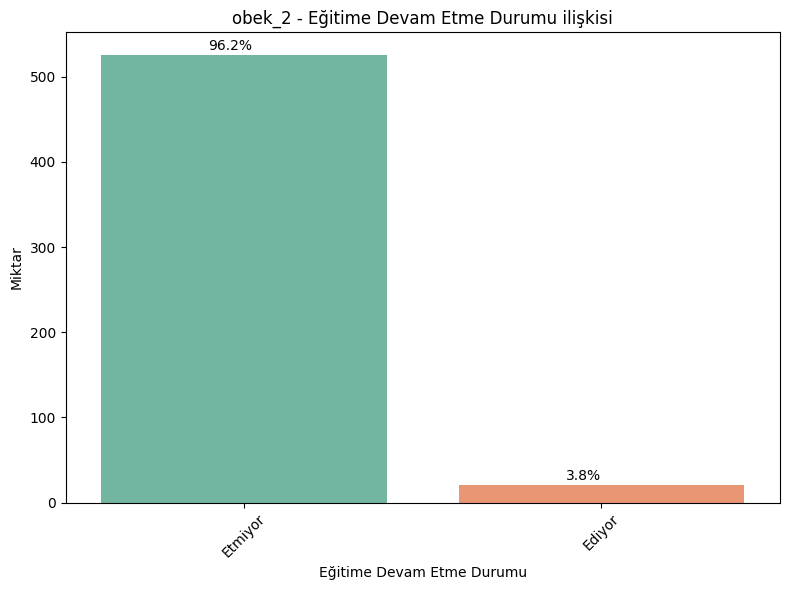

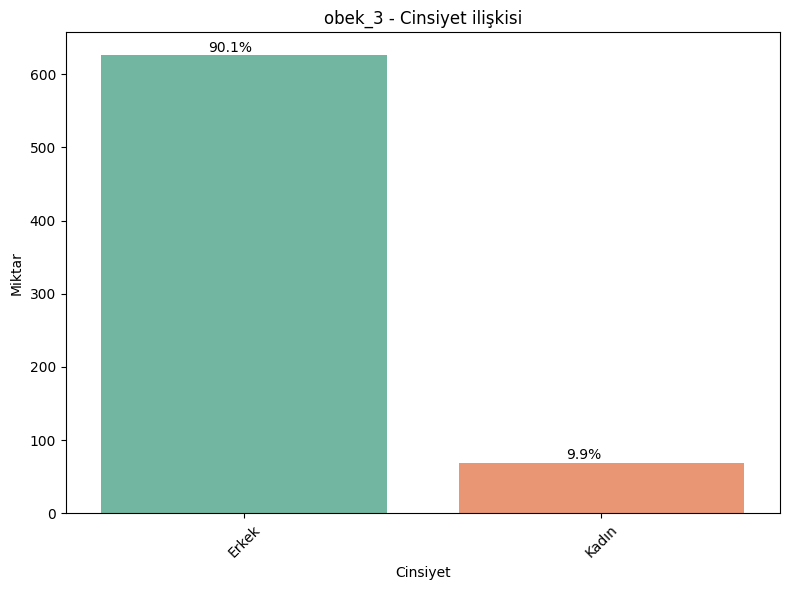

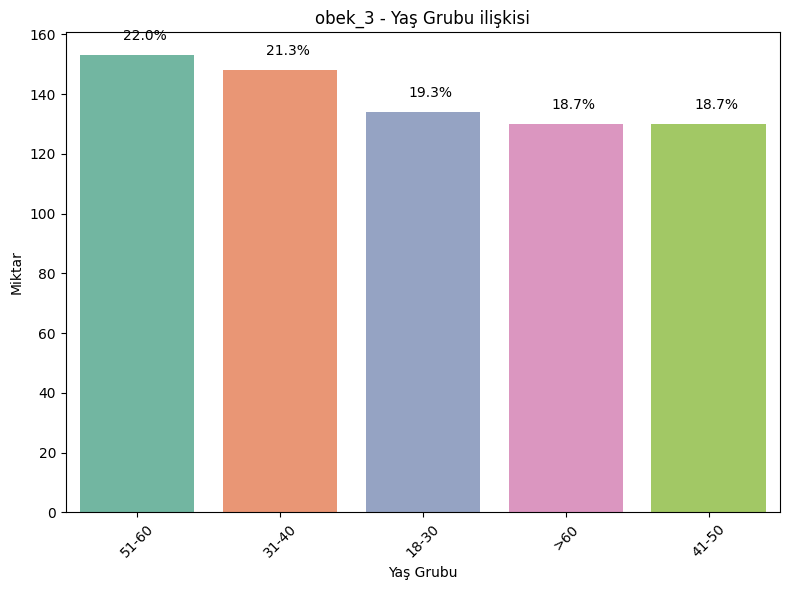

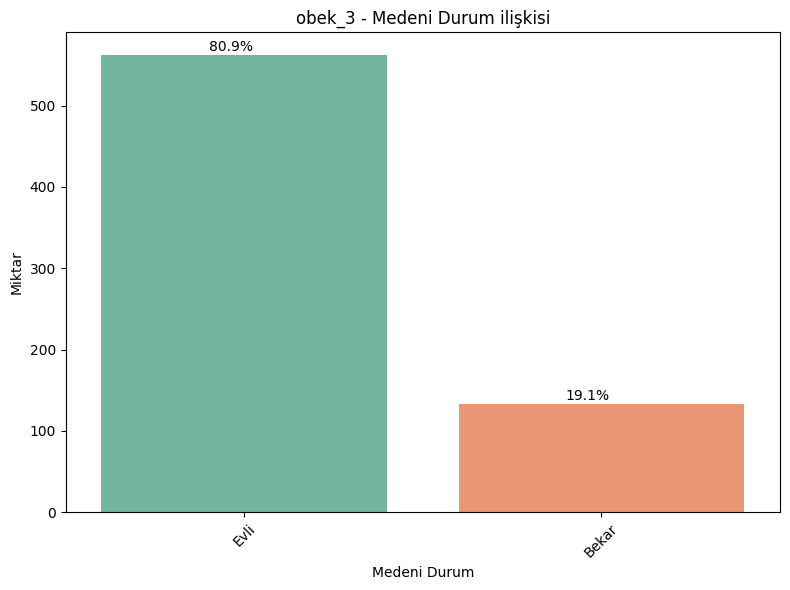

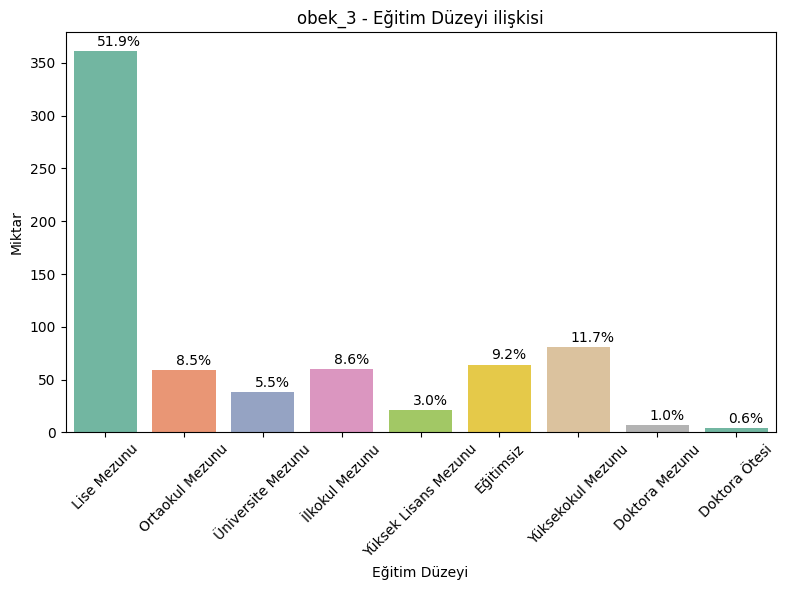

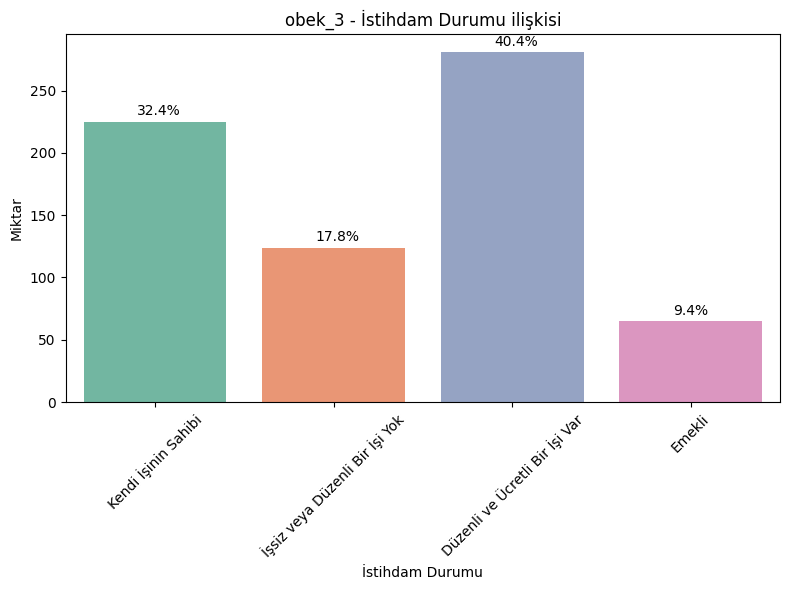

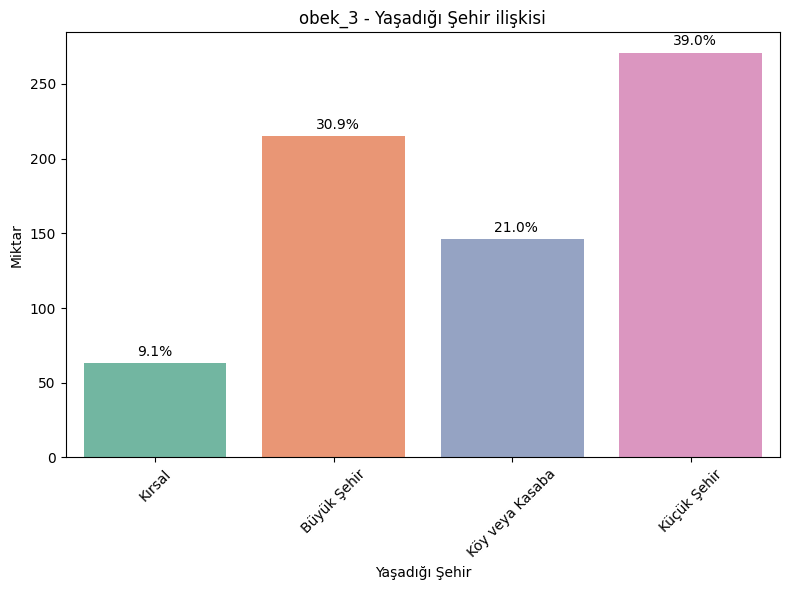

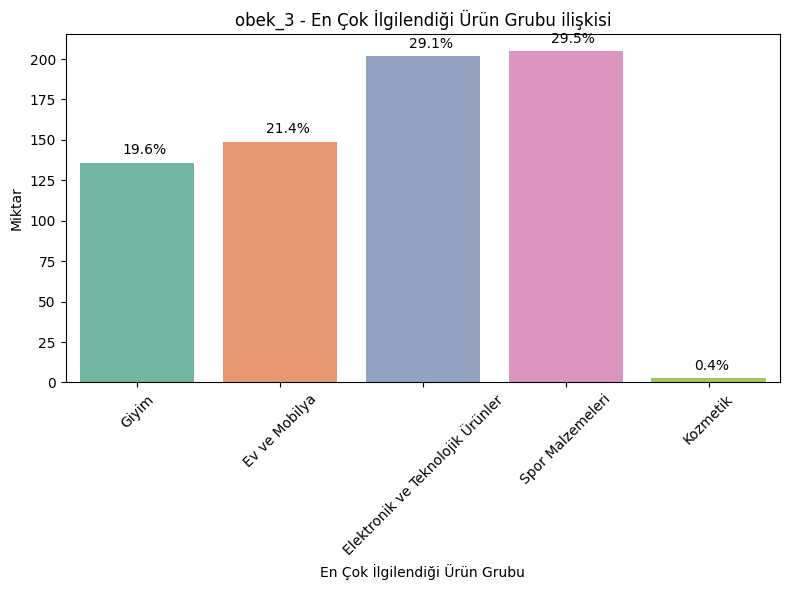

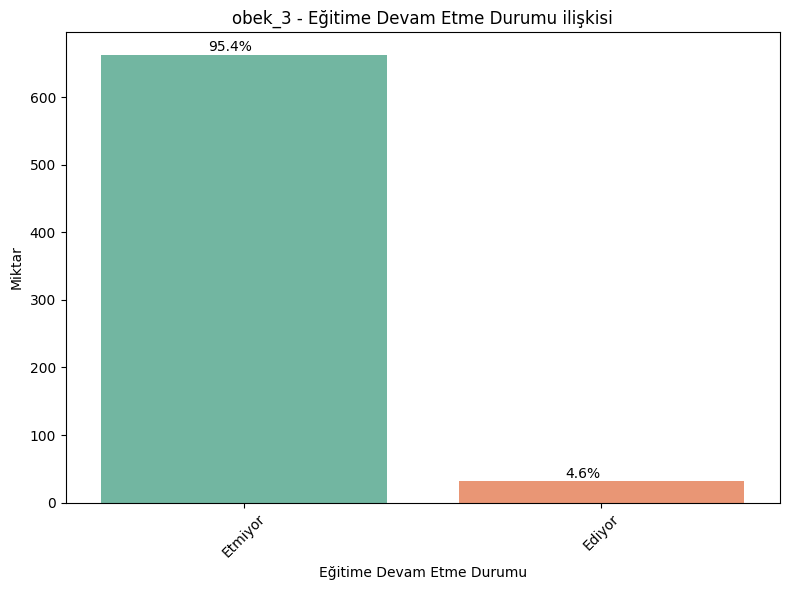

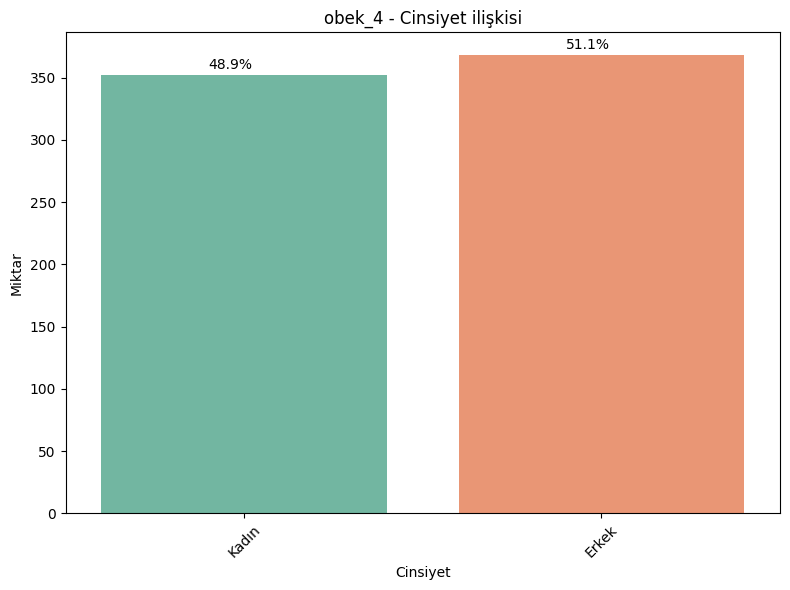

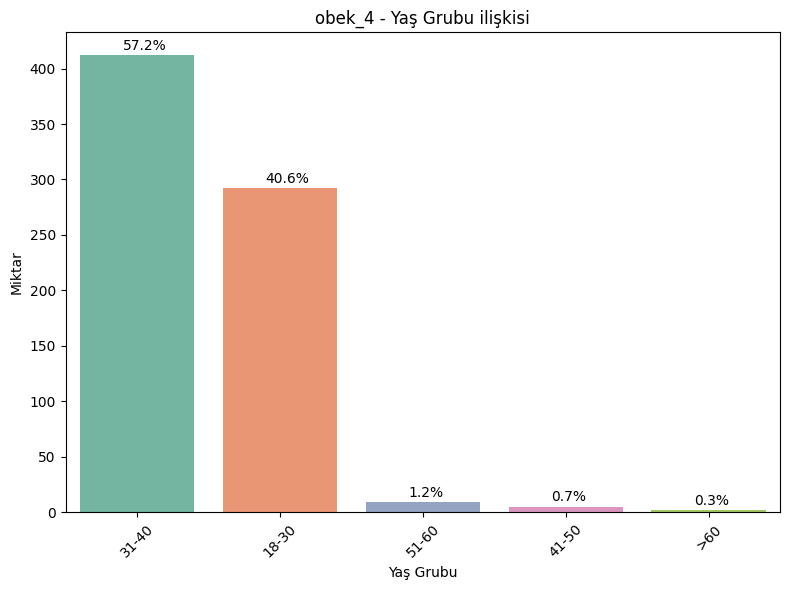

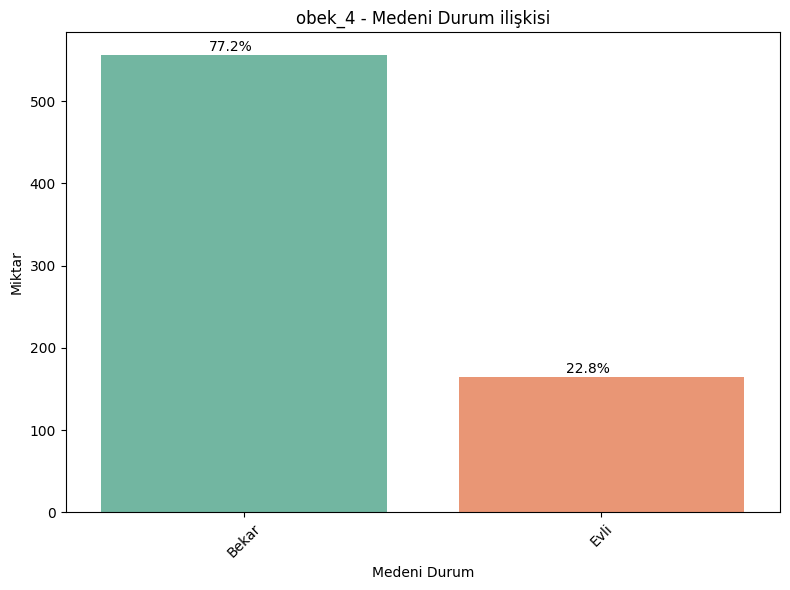

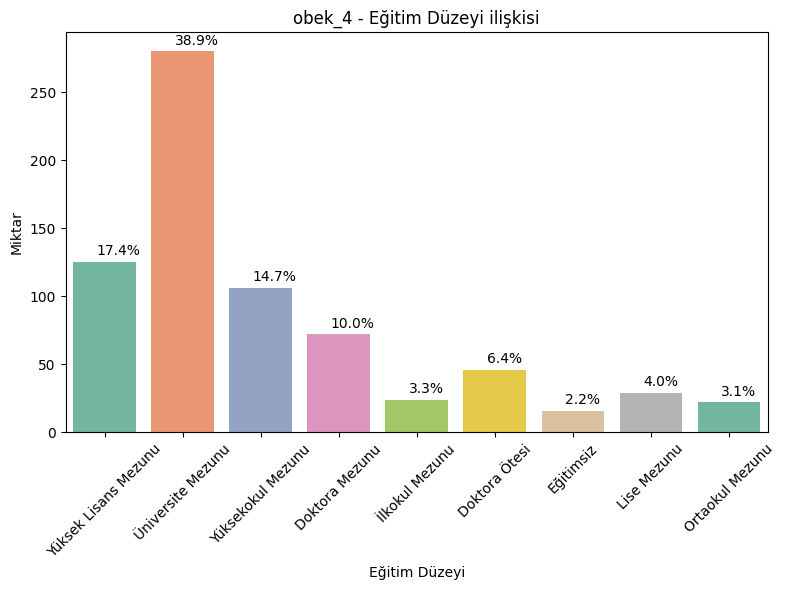

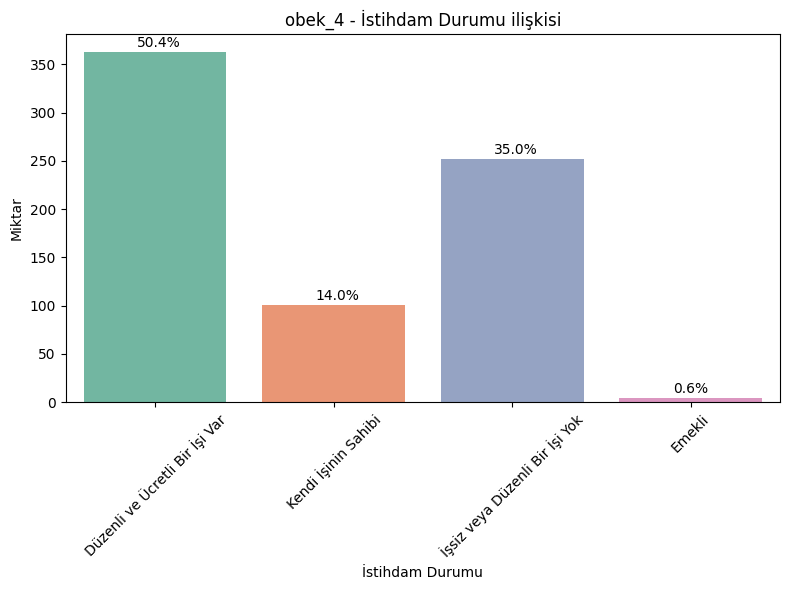

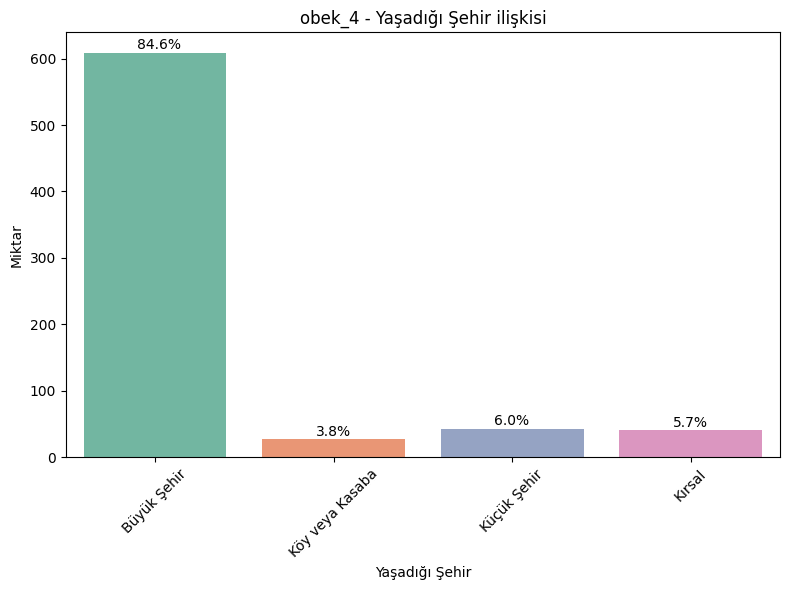

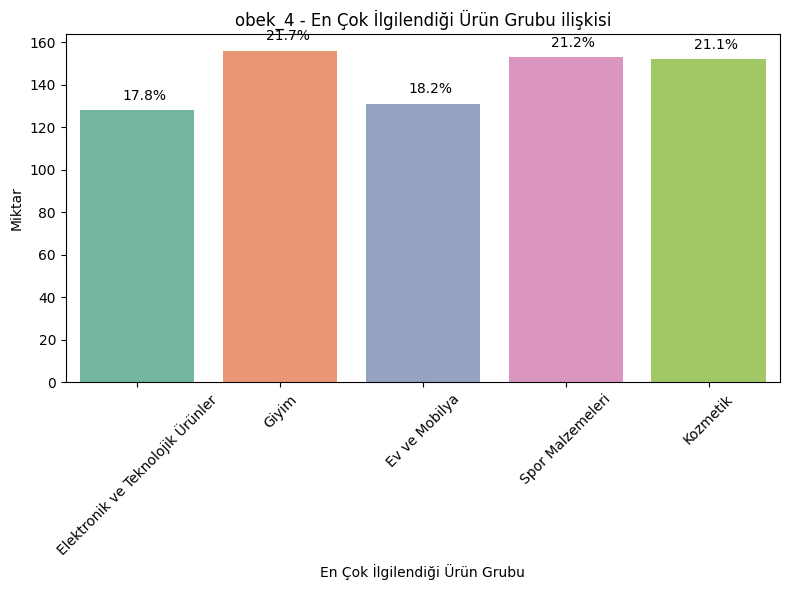

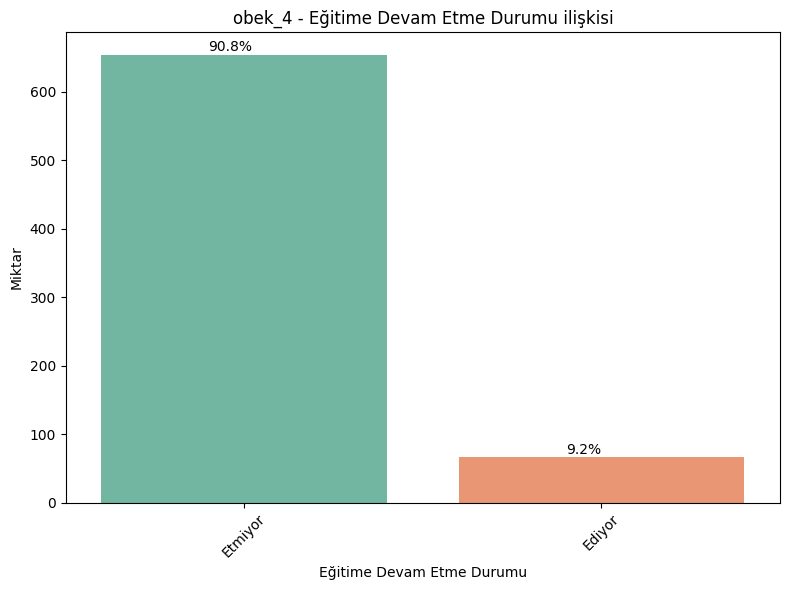

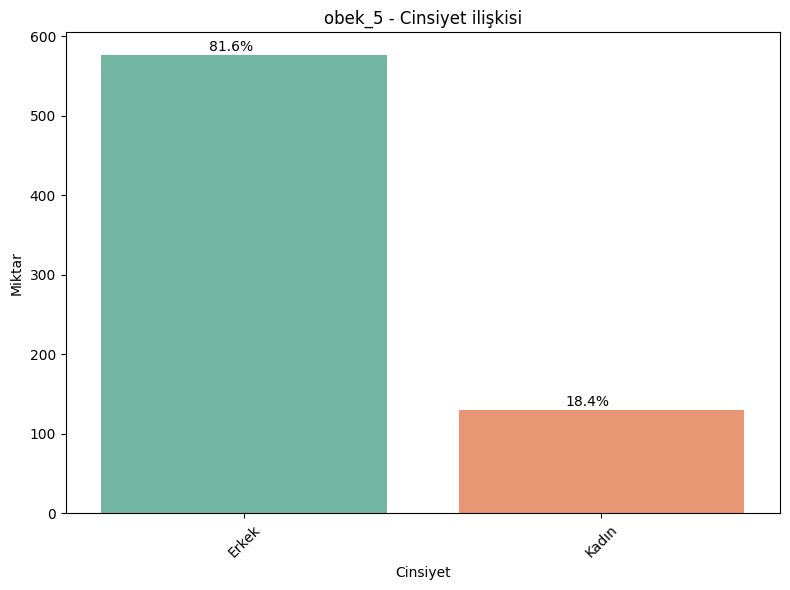

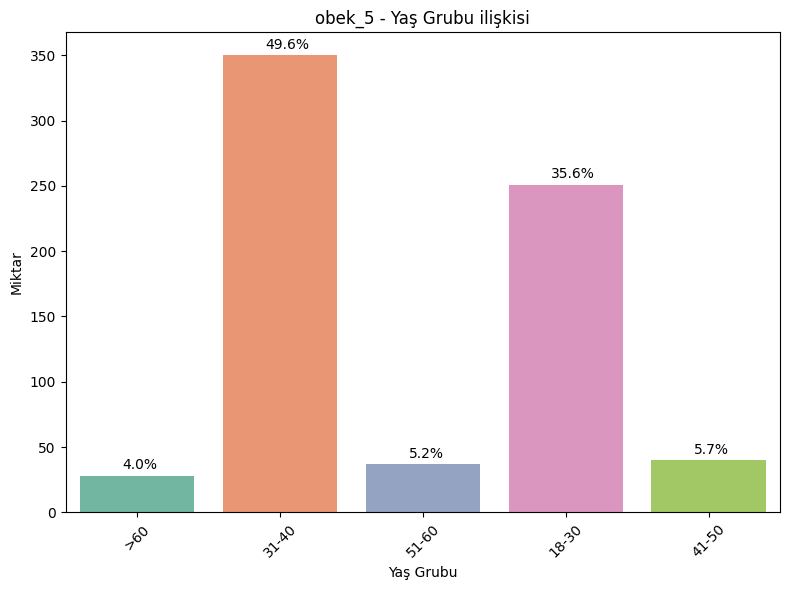

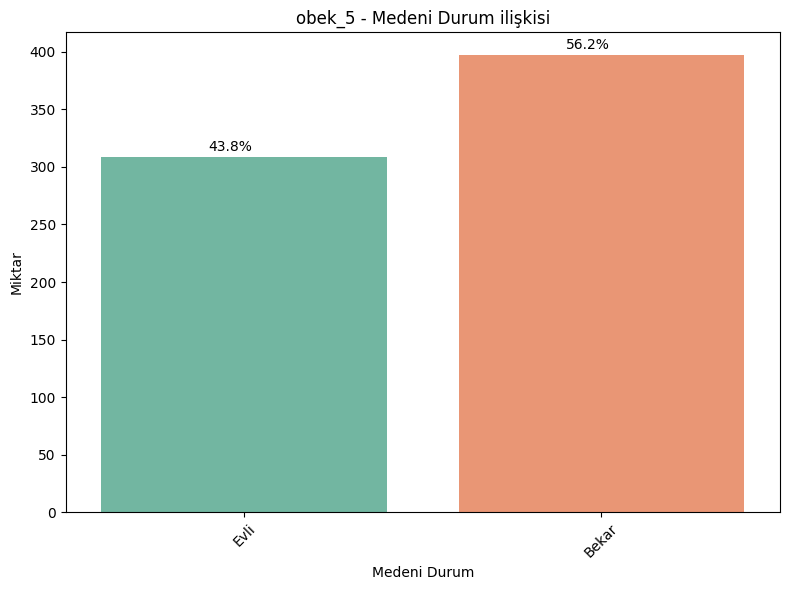

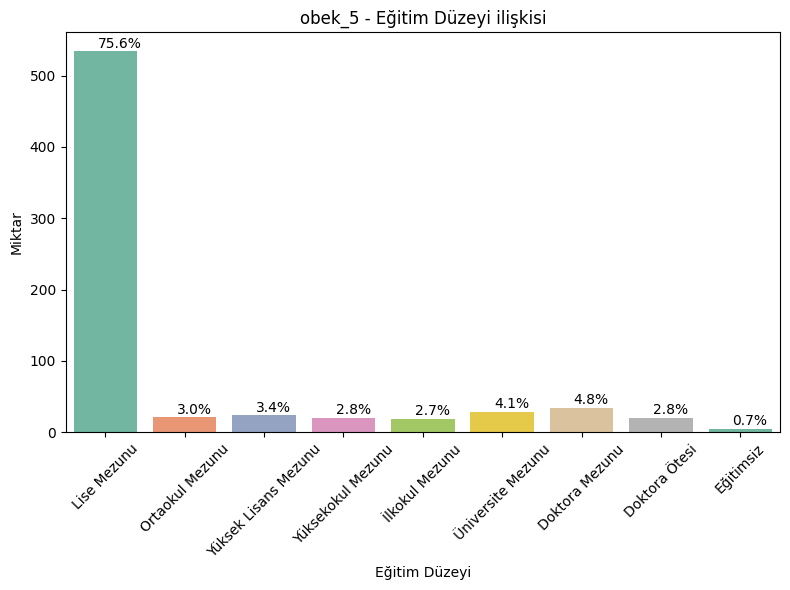

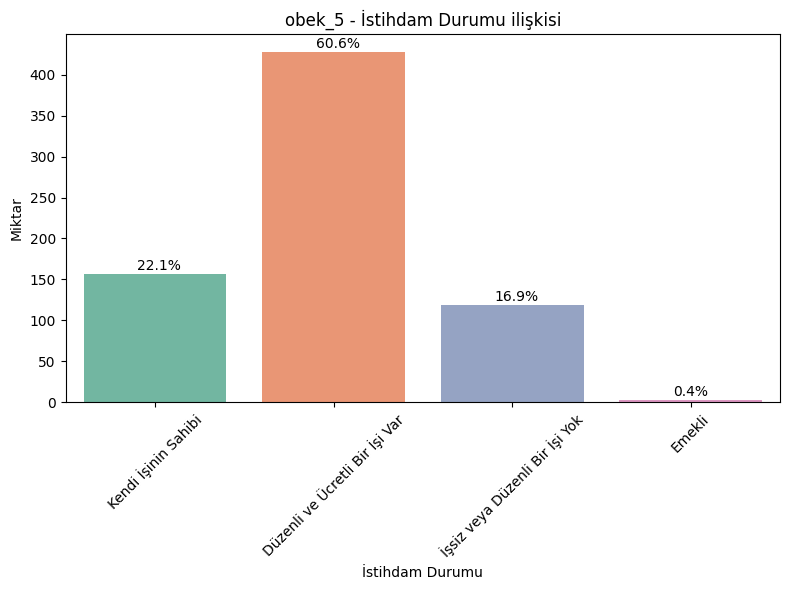

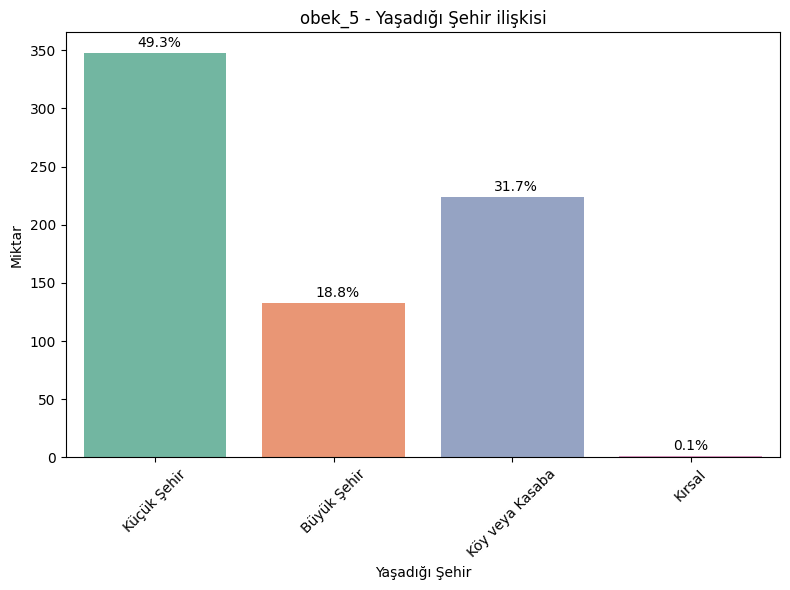

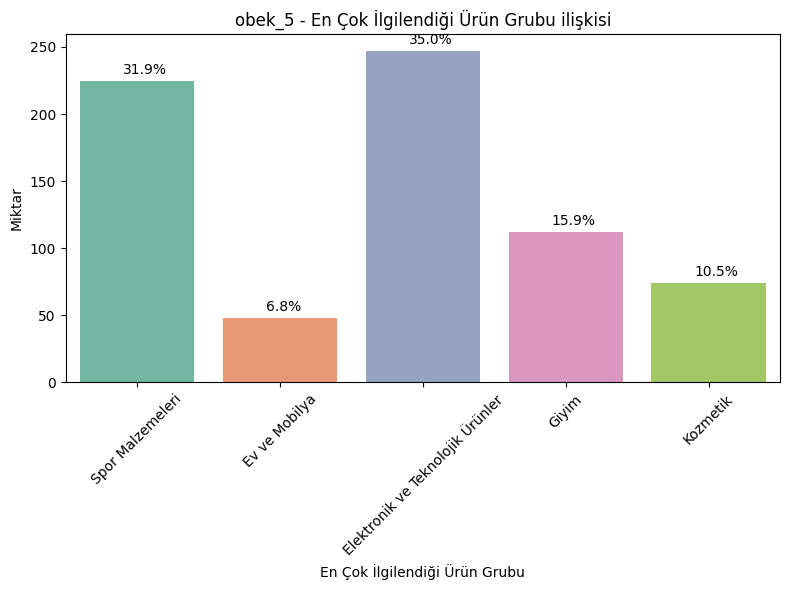

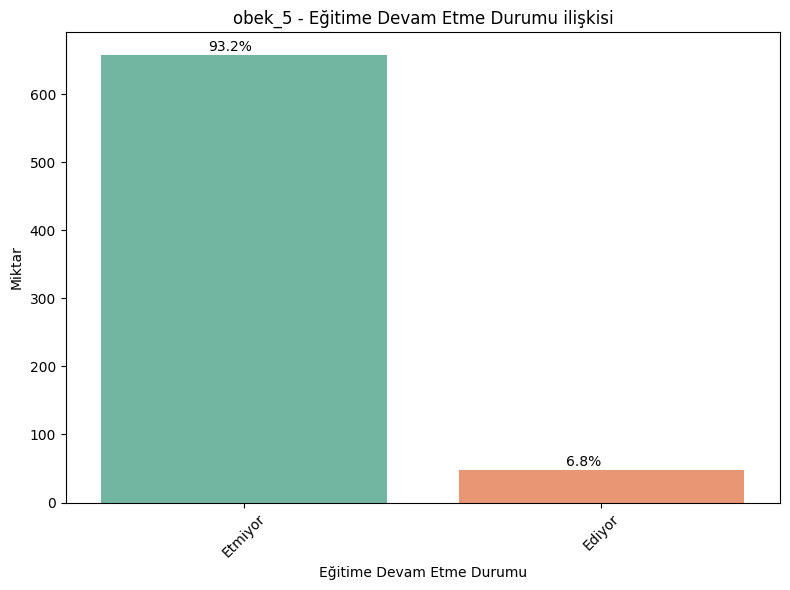

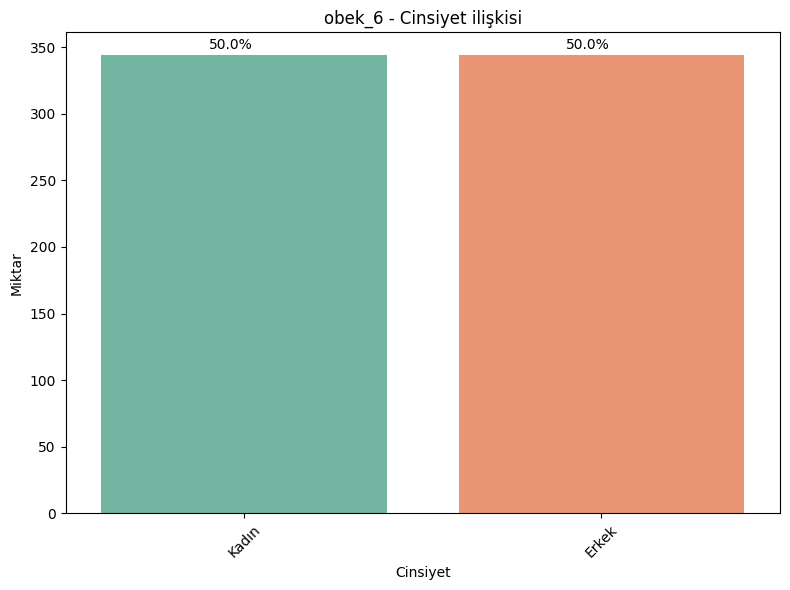

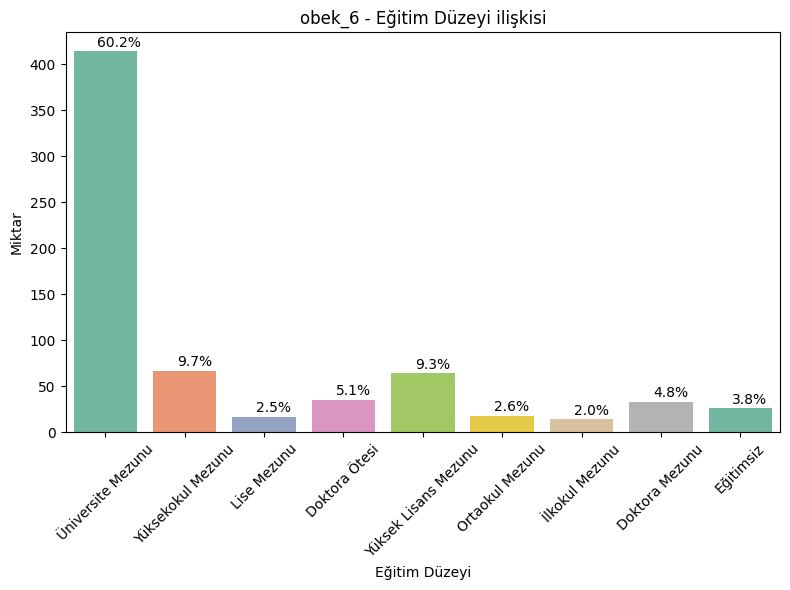

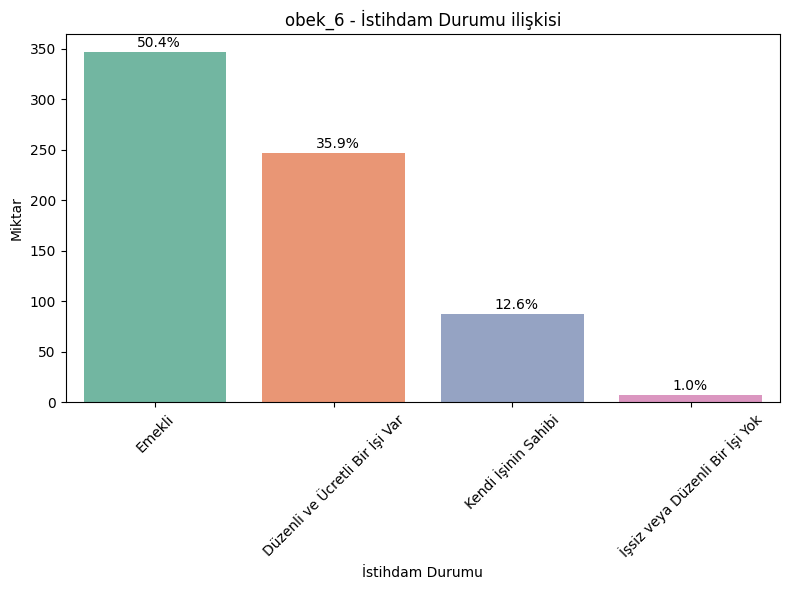

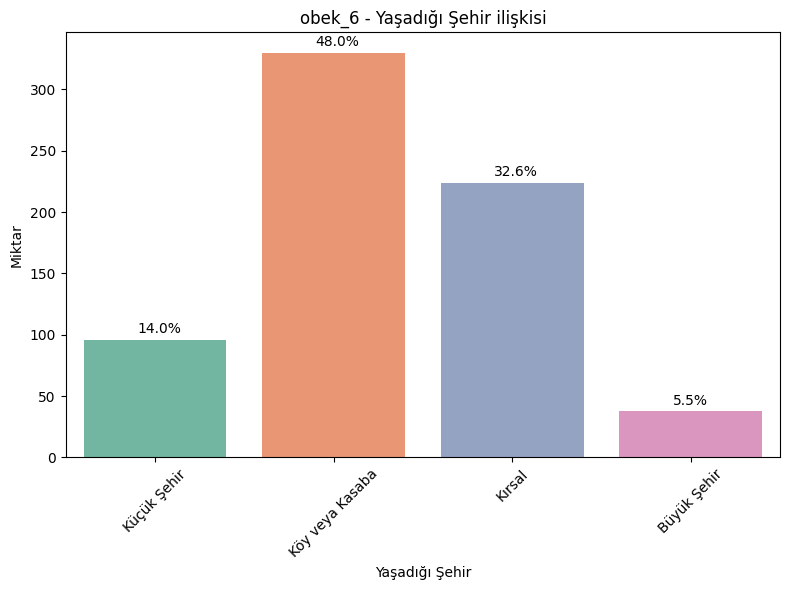

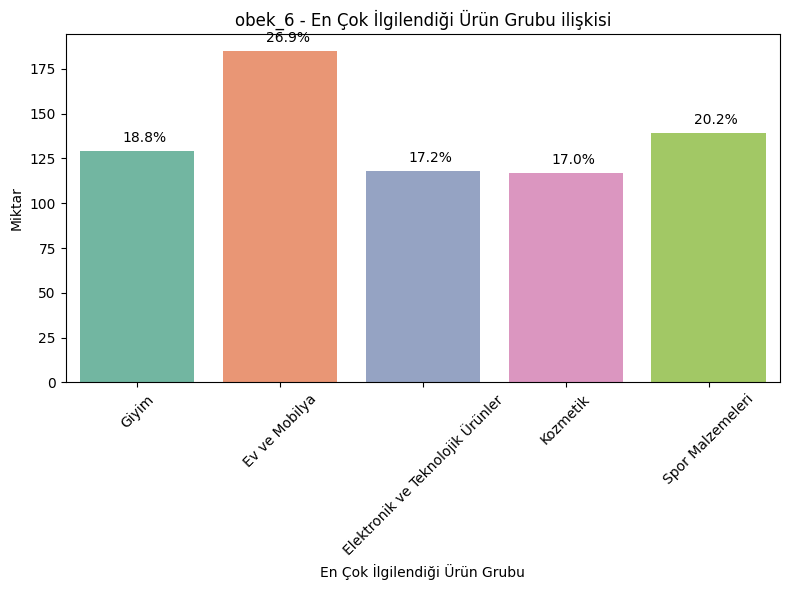

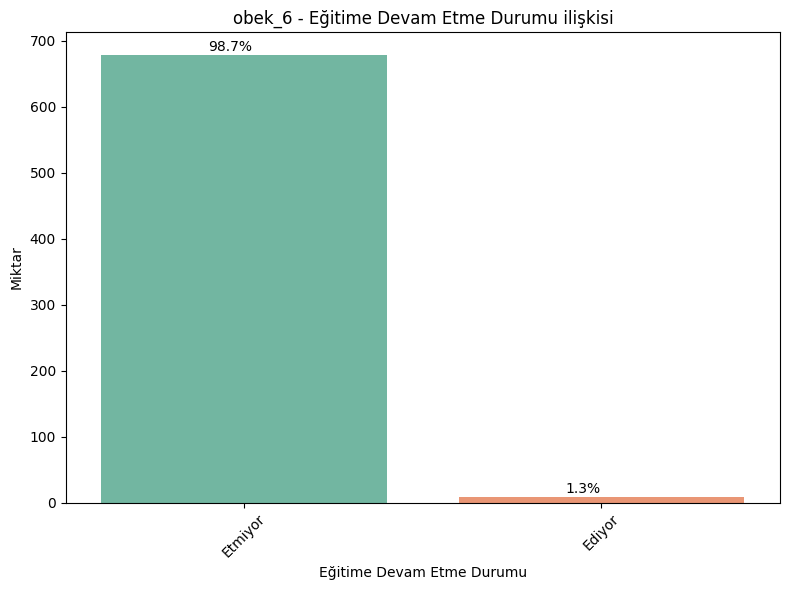

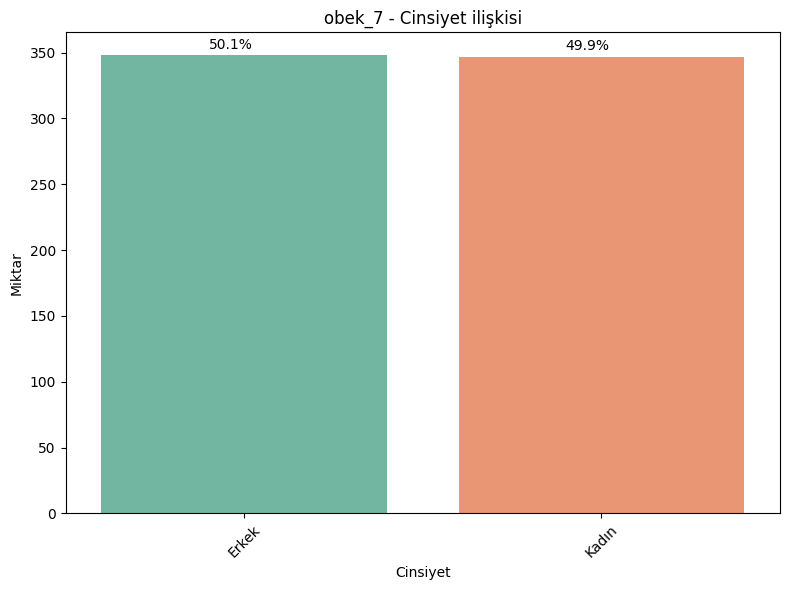

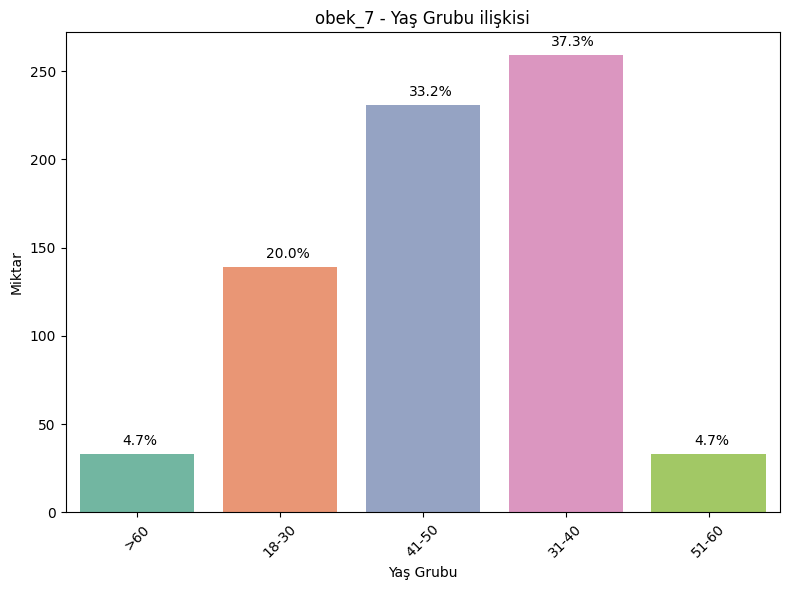

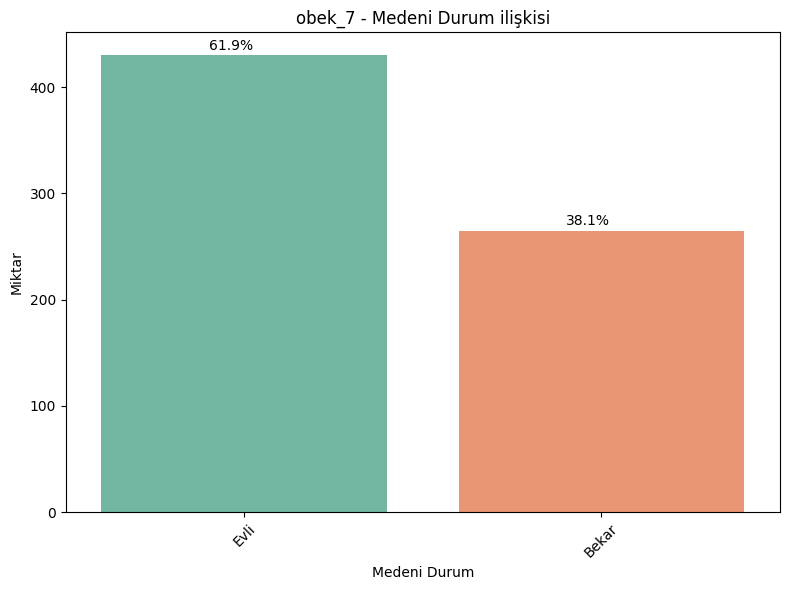

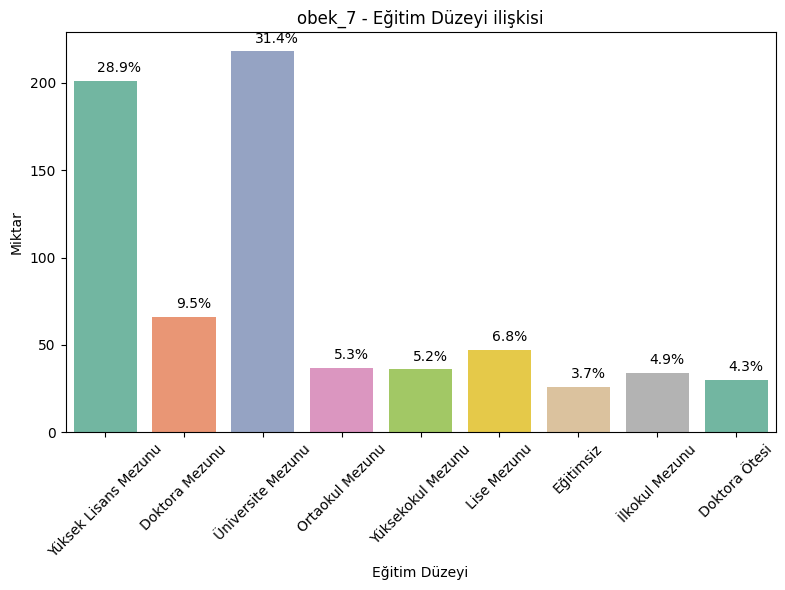

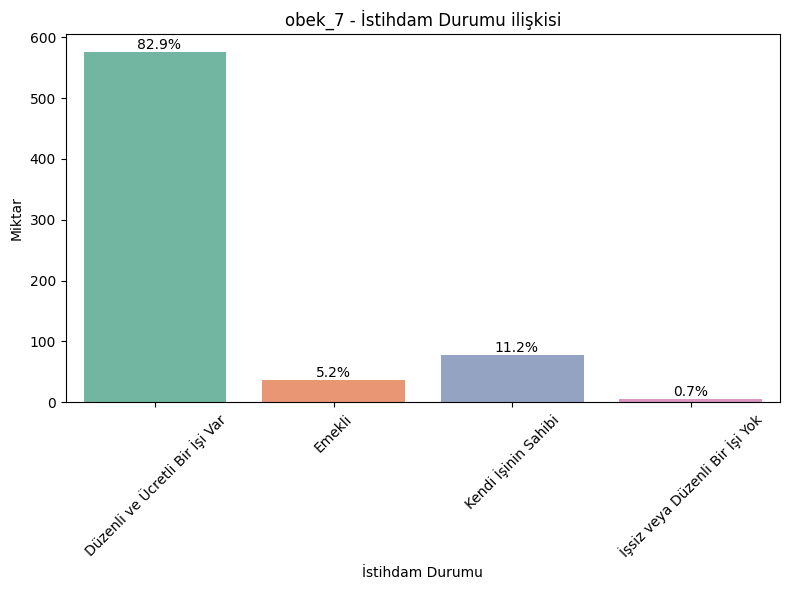

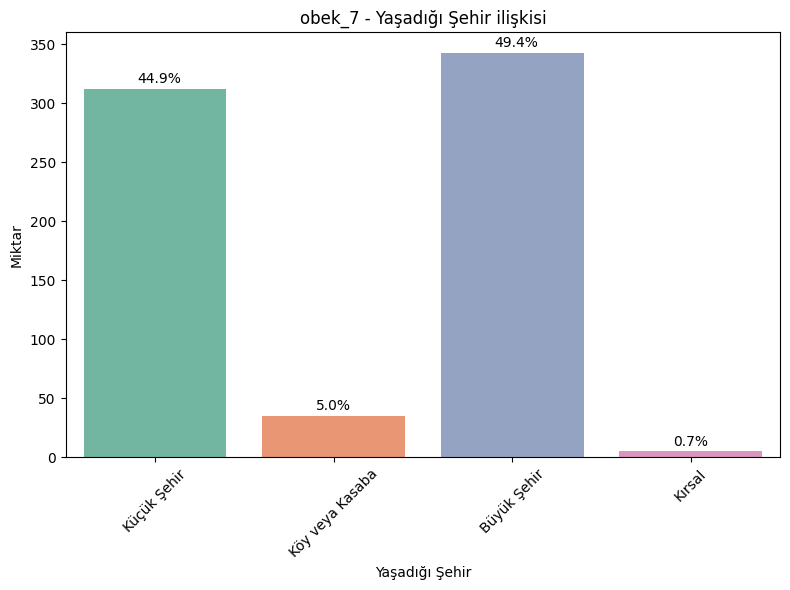

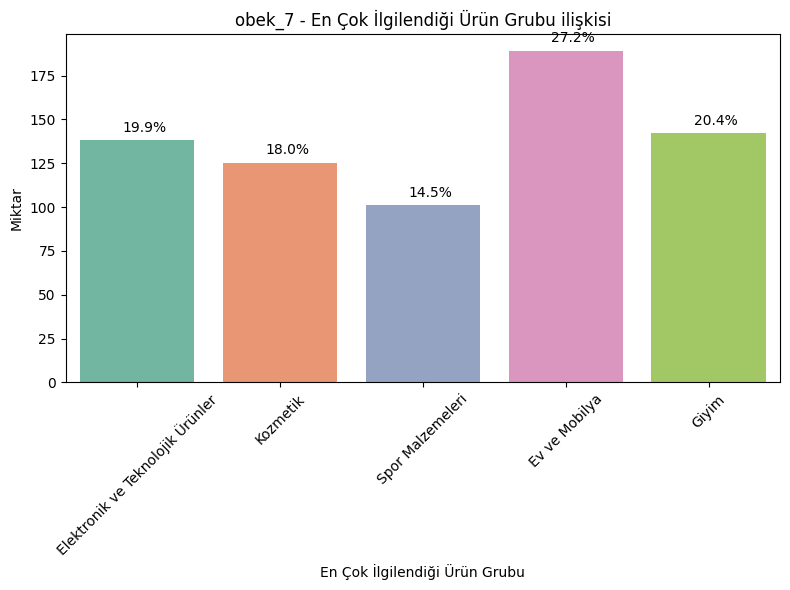

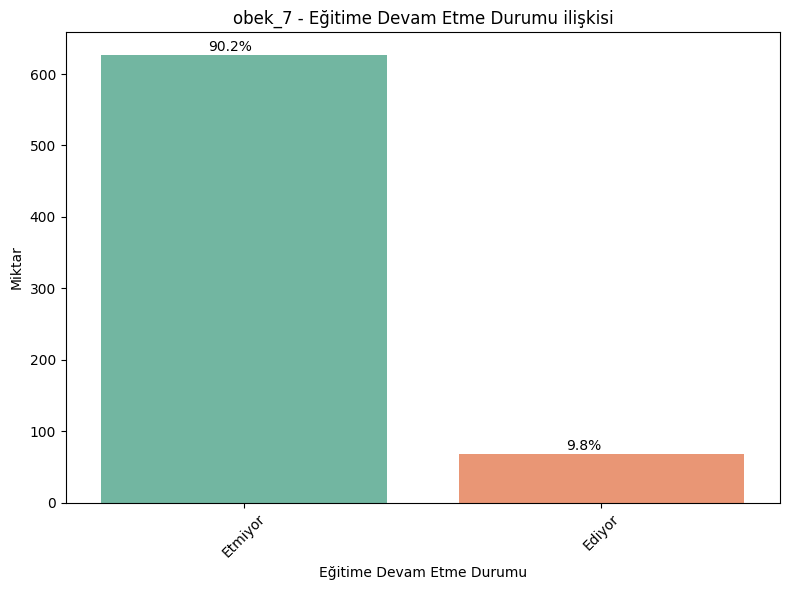

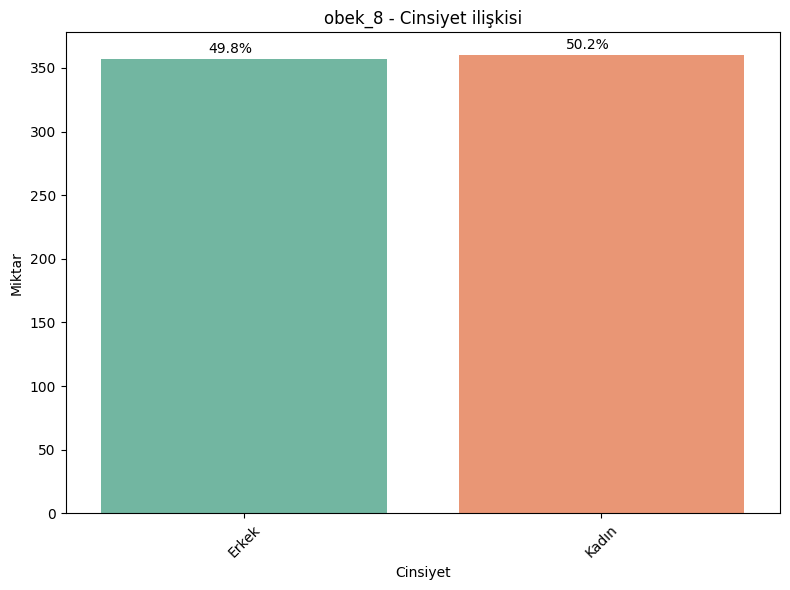

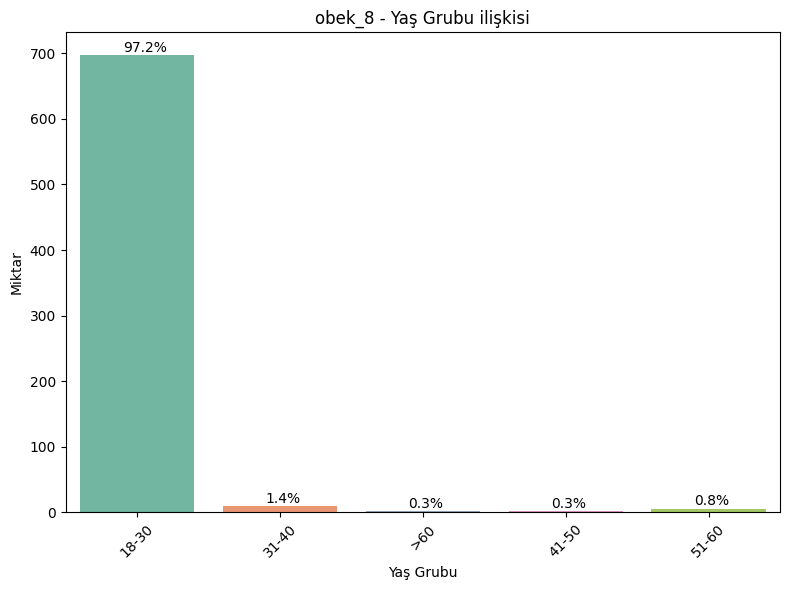

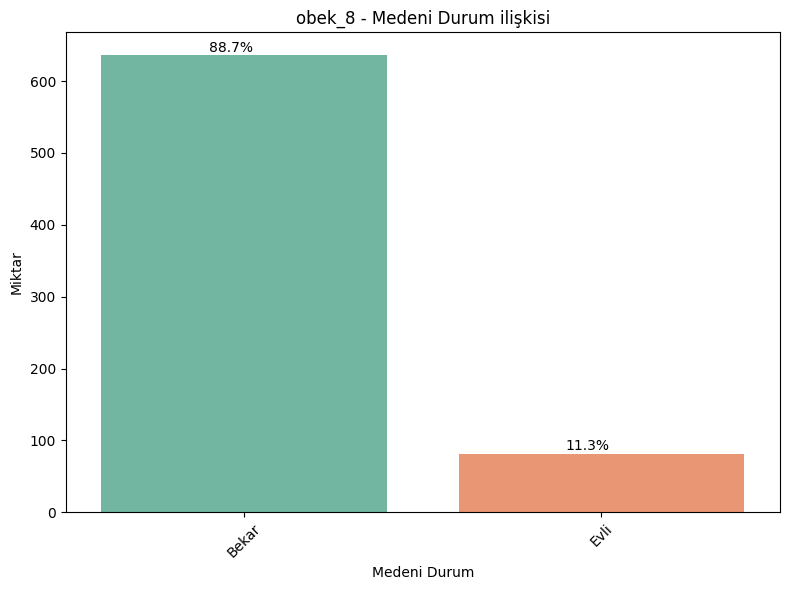

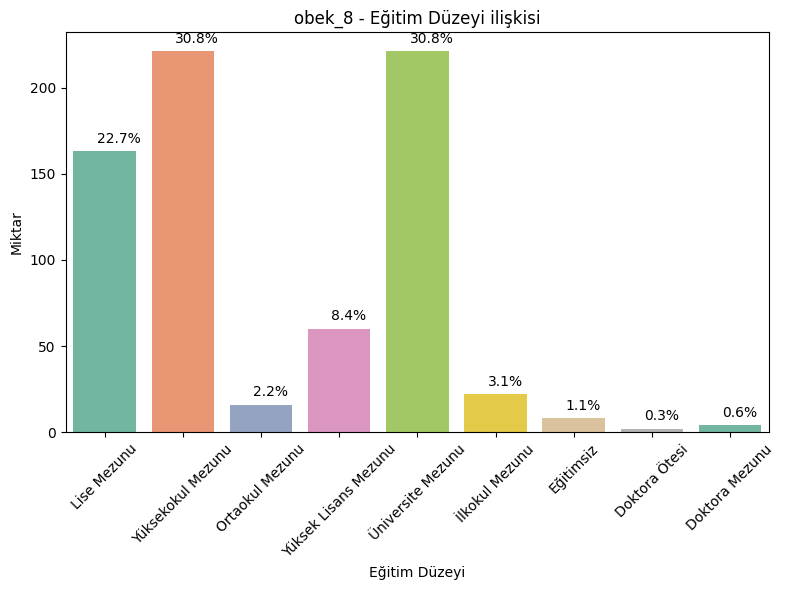

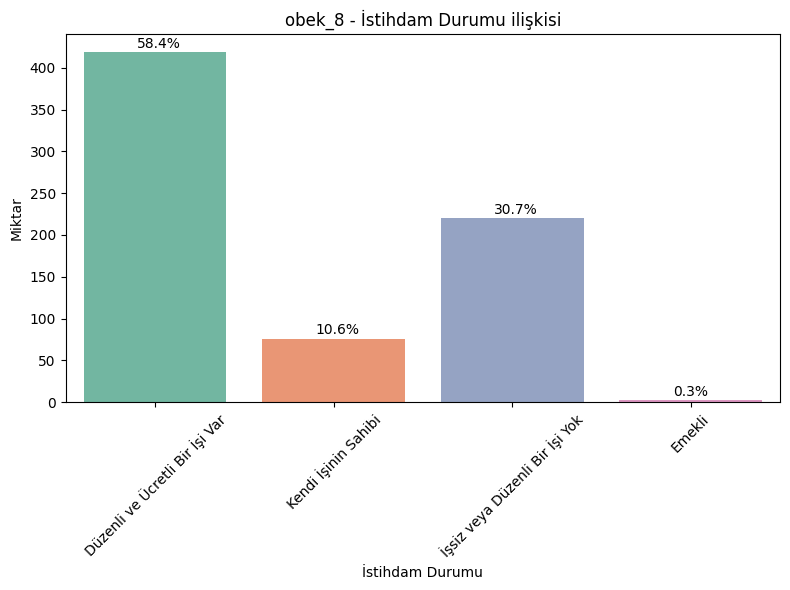

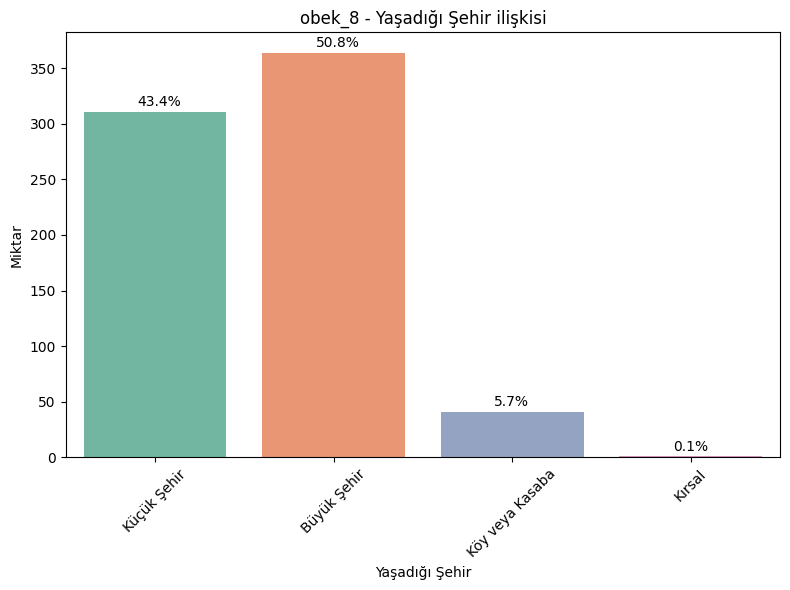

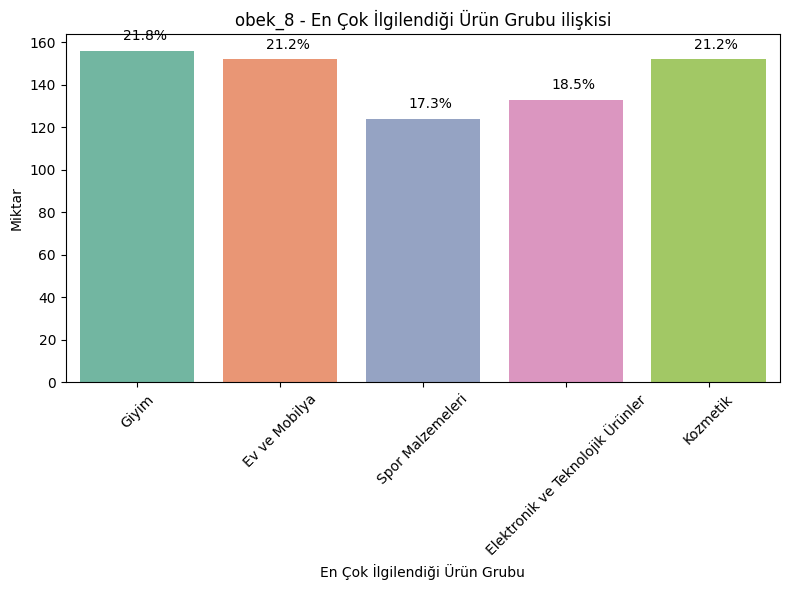

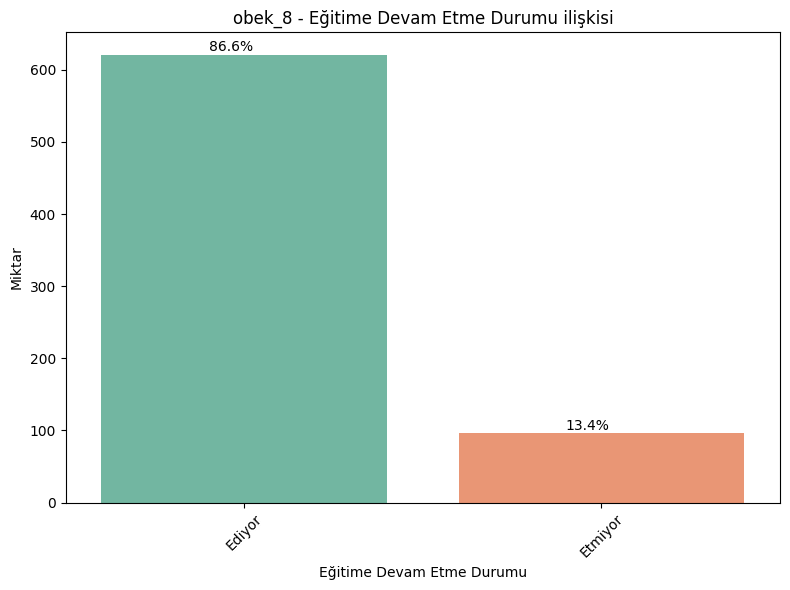

In [54]:
def obeklere_gore_kategorik_degiskenlerin_iliskisi():
    obekler = sorted(train_df["Öbek İsmi"].unique()) # Öbekleri sıralama
    kategorik_degiskenler = ["Cinsiyet", "Yaş Grubu", "Medeni Durum", "Eğitim Düzeyi", "İstihdam Durumu",
                             "Yaşadığı Şehir", "En Çok İlgilendiği Ürün Grubu","Eğitime Devam Etme Durumu"]

    for obek in obekler:
        train_df_obekler = train_df[train_df["Öbek İsmi"] == obek]

        for kategorik_degisken in kategorik_degiskenler:
            plt.figure(figsize=(8, 6))

            ax = sns.countplot(x=kategorik_degisken, data=train_df_obekler, palette="Set2")
            plt.title(f"{obek} - {kategorik_degisken} ilişkisi")
            plt.xlabel(kategorik_degisken)
            plt.ylabel("Miktar")
            plt.xticks(rotation=45)

            total = len(train_df_obekler)
            for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_height() / total)
                x = p.get_x() + p.get_width() / 2 - 0.1
                y = p.get_y() + p.get_height() + 5
                ax.annotate(percentage, (x, y))

            plt.tight_layout()
            plt.show()
obeklere_gore_kategorik_degiskenlerin_iliskisi()

In [55]:
#Kategorik değişkenlerin öbeklere göre dağılımını da görselleştirerek daha iyi inceleme yapabiliriz.
kategorik_degiskenler = ["Cinsiyet", "Yaş Grubu", "Medeni Durum", "Eğitim Düzeyi", "İstihdam Durumu",
                             "Yaşadığı Şehir", "En Çok İlgilendiği Ürün Grubu","Eğitime Devam Etme Durumu"]
for kategorik_degisken in kategorik_degiskenler:
    fig = px.histogram(train_df,x=kategorik_degisken, color="Öbek İsmi", barmode="group",title=(f"{kategorik_degisken} ve Öbek İsmi"))

    fig.show()

# Özellik Çıkarımı/Mühendisliği (Feature Extraction/Engineering)


In [56]:
def ozellik_cikarimi():
    """

    Veri seti için çeşitli özellik çıkarımı işlemleri yapar.

    """
    ###### NEW_Sepete Atılan Ürünü Alım Oranı ######
    # burada 1 eklenmesinin sebebi "Yıllık Ortalama Sipariş Verilen Ürün Adedi" değeri 0 olan gözlemler yüzündendir,
    # 0'a bölünememe hatasından kaçınmak için.

    # train_df
    train_df["NEW_Sepete Atılan Ürünü Alım Oranı"] = train_df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] / (
                train_df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] + 1)

    # test_df
    test_df["NEW_Sepete Atılan Ürünü Alım Oranı"] = test_df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] / (
                test_df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] + 1)

    ###### NEW_Sepete Atılıp Alınmayan Ürün Adedi ######
    # train_df
    train_df["NEW_Sepete Atılıp Alınmayan Ürün Adedi"] = train_df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] - \
                                                         train_df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
    # test_df
    test_df["NEW_Sepete Atılıp Alınmayan Ürün Adedi"] = test_df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] - test_df[
        "Yıllık Ortalama Sipariş Verilen Ürün Adedi"]

    ###### NEW_Yıllık Ortalama Gelir Segmentasyonu ######
    # train_df
    train_df.loc[(train_df['Yıllık Ortalama Gelir'] <= 100000), 'NEW_Yıllık Ortalama Gelir Segmentasyonu'] = 'Fakir'
    train_df.loc[((train_df['Yıllık Ortalama Gelir'] <= train_df['Yıllık Ortalama Gelir'].mean()) & (train_df[
                                                                                                         'Yıllık Ortalama Gelir'] > 100000)), 'NEW_Yıllık Ortalama Gelir Segmentasyonu'] = 'Ortalamanın Altında'
    train_df.loc[((train_df['Yıllık Ortalama Gelir'] > train_df['Yıllık Ortalama Gelir'].mean()) & (
                train_df['Yıllık Ortalama Gelir'] <= (train_df['Yıllık Ortalama Gelir'].mean() + train_df[
            'Yıllık Ortalama Gelir'].std()))), 'NEW_Yıllık Ortalama Gelir Segmentasyonu'] = 'Ortalamanın Üstünde'
    train_df.loc[(train_df['Yıllık Ortalama Gelir'] > (train_df['Yıllık Ortalama Gelir'].mean() + train_df[
        'Yıllık Ortalama Gelir'].std())), 'NEW_Yıllık Ortalama Gelir Segmentasyonu'] = 'Zengin'


    # test_df
    test_df.loc[(test_df['Yıllık Ortalama Gelir'] <= 100000), 'NEW_Yıllık Ortalama Gelir Segmentasyonu'] = 'Fakir'
    test_df.loc[((test_df['Yıllık Ortalama Gelir'] <= test_df['Yıllık Ortalama Gelir'].mean()) & (test_df[
                                                                                                      'Yıllık Ortalama Gelir'] > 100000)), 'NEW_Yıllık Ortalama Gelir Segmentasyonu'] = 'Ortalamanın Altında'
    test_df.loc[((test_df['Yıllık Ortalama Gelir'] > test_df['Yıllık Ortalama Gelir'].mean()) & (
                test_df['Yıllık Ortalama Gelir'] <= (test_df['Yıllık Ortalama Gelir'].mean() + test_df[
            'Yıllık Ortalama Gelir'].std()))), 'NEW_Yıllık Ortalama Gelir Segmentasyonu'] = 'Ortalamanın Üstünde'
    test_df.loc[(test_df['Yıllık Ortalama Gelir'] > (test_df['Yıllık Ortalama Gelir'].mean() + test_df[
        'Yıllık Ortalama Gelir'].std())), 'NEW_Yıllık Ortalama Gelir Segmentasyonu'] = 'Zengin'


    ###### NEW_Yas_Grubu_Seviye ######
    # train_df
    train_df.loc[
        ((train_df['Yaş Grubu'] == "18-30") | (train_df['Yaş Grubu'] == "31-40")), 'NEW_Yas_Grubu_Seviye'] = 'Genc'
    train_df.loc[((train_df['Yaş Grubu'] == "41-50")), 'NEW_Yas_Grubu_Seviye'] = 'OrtaYasli'
    train_df.loc[
        ((train_df['Yaş Grubu'] == "51-60") | (train_df['Yaş Grubu'] == ">60")), 'NEW_Yas_Grubu_Seviye'] = 'Yasli'

    # test_df
    test_df.loc[
        ((test_df['Yaş Grubu'] == "18-30") | (test_df['Yaş Grubu'] == "31-40")), 'NEW_Yas_Grubu_Seviye'] = 'Genc'
    test_df.loc[((test_df['Yaş Grubu'] == "41-50")), 'NEW_Yas_Grubu_Seviye'] = 'OrtaYasli'
    test_df.loc[((test_df['Yaş Grubu'] == "51-60") | (test_df['Yaş Grubu'] == ">60")), 'NEW_Yas_Grubu_Seviye'] = 'Yasli'

    ###### NEW_Yas Cinsiyet Dağılımı ######
    # train_df
    train_df.loc[((train_df['NEW_Yas_Grubu_Seviye'] == "Genc") | (
                train_df['Cinsiyet'] == "Erkek")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'GencErkek'
    train_df.loc[((train_df['NEW_Yas_Grubu_Seviye'] == "Genc") | (
                train_df['Cinsiyet'] == "Kadın")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'GencKadin'
    train_df.loc[((train_df['NEW_Yas_Grubu_Seviye'] == "OrtaYasli") | (
                train_df['Cinsiyet'] == "Erkek")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'OrtaYasliErkek'
    train_df.loc[((train_df['NEW_Yas_Grubu_Seviye'] == "OrtaYasli") | (
                train_df['Cinsiyet'] == "Kadın")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'OrtaYasliKadin'
    train_df.loc[((train_df['NEW_Yas_Grubu_Seviye'] == "Yasli") | (
                train_df['Cinsiyet'] == "Erkek")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'YasliErkek'
    train_df.loc[((train_df['NEW_Yas_Grubu_Seviye'] == "Yasli") | (
                train_df['Cinsiyet'] == "Kadın")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'YasliKadin'

    # test_df
    test_df.loc[((test_df['NEW_Yas_Grubu_Seviye'] == "Genc") | (
                test_df['Cinsiyet'] == "Erkek")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'GencErkek'
    test_df.loc[((test_df['NEW_Yas_Grubu_Seviye'] == "Genc") | (
                test_df['Cinsiyet'] == "Kadın")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'GencKadin'
    test_df.loc[((test_df['NEW_Yas_Grubu_Seviye'] == "OrtaYasli") | (
                test_df['Cinsiyet'] == "Erkek")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'OrtaYasliErkek'
    test_df.loc[((test_df['NEW_Yas_Grubu_Seviye'] == "OrtaYasli") | (
                test_df['Cinsiyet'] == "Kadın")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'OrtaYasliKadin'
    test_df.loc[((test_df['NEW_Yas_Grubu_Seviye'] == "Yasli") | (
                test_df['Cinsiyet'] == "Erkek")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'YasliErkek'
    test_df.loc[((test_df['NEW_Yas_Grubu_Seviye'] == "Yasli") | (
                test_df['Cinsiyet'] == "Kadın")), 'NEW_Yas_Cinsiyet_Dagilimi'] = 'YasliKadin'

    ###### NEW_Maas_Hanesi ######
    # train_df
    train_df.loc[((train_df['Yıllık Ortalama Gelir'] / 1000000) >= 1), 'NEW_Maas_Hanesi'] = 7
    train_df.loc[(((train_df['Yıllık Ortalama Gelir'] / 1000000) <= 1) & (
                (train_df['Yıllık Ortalama Gelir'] / 100000) >= 1)), 'NEW_Maas_Hanesi'] = 6
    train_df.loc[(((train_df['Yıllık Ortalama Gelir'] / 1000000) <= 1) & (
                (train_df['Yıllık Ortalama Gelir'] / 100000) <= 1) & (
                              (train_df['Yıllık Ortalama Gelir'] / 10000) >= 1)), 'NEW_Maas_Hanesi'] = 5

    # test_df
    test_df.loc[((test_df['Yıllık Ortalama Gelir'] / 1000000) >= 1), 'NEW_Maas_Hanesi'] = 7
    test_df.loc[(((test_df['Yıllık Ortalama Gelir'] / 1000000) <= 1) & (
                (test_df['Yıllık Ortalama Gelir'] / 100000) >= 1)), 'NEW_Maas_Hanesi'] = 6
    test_df.loc[(((test_df['Yıllık Ortalama Gelir'] / 1000000) <= 1) & (
                (test_df['Yıllık Ortalama Gelir'] / 100000) <= 1) & (
                             (test_df['Yıllık Ortalama Gelir'] / 10000) >= 1)), 'NEW_Maas_Hanesi'] = 5

ozellik_cikarimi()


In [57]:
#Hedef değişkenin diğer değişkenlerden farklı işlemlere tabii tutulması gerektiğinden,
#cat_cols listesinden çıkarılmalıdır.
cat_cols, num_cols, cat_but_car = grab_col_names(train_df)
cat_cols = [col for col in cat_cols if col != "Öbek İsmi"]


Observations: 5460
Variables: 19
cat_cols: 13
num_cols: 6
cat_but_car: 0
num_but_cat: 1


# Encoding

## Label Encoding

### Train veri setine label encoder uygulanması

In [58]:
label_encoders = {}
for column in cat_cols:
    le = LabelEncoder()
    train_df[column] = le.fit_transform(train_df[column])
    label_encoders[column] = le

### Test veri setine label encoder uygulanması

In [59]:
label_encoders = {}
for column in cat_cols:
    le = LabelEncoder()
    test_df[column] = le.fit_transform(test_df[column])
    label_encoders[column] = le

### Hedef değişkene label encoding uygulanması

In [60]:
target_encoder = LabelEncoder()
train_df['Öbek İsmi'] = target_encoder.fit_transform(train_df['Öbek İsmi'])

## One Hot Encoding

### Train veri setine one hot encoding uygulanması

In [61]:
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)

##Test veri setine one hot encoding uygulanması

In [62]:
test_df = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)

##Train veri setinin model eğitimi için hazırlanması

In [63]:
X = train_df.drop('Öbek İsmi', axis=1)
y = train_df['Öbek İsmi']

# Scaling işlemleri

In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
test_data_scaled = scaler.transform(test_df)

# Model kurulumu

## Holdout yöntemi uygulanması

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Base modeller ile hiperparametre optimizasyonu yapılmış modellerin karşılaştırılması


In [66]:
rf_params = {'n_estimators': np.array([868]),
            'min_samples_split': np.array([10]),
            'min_samples_leaf': np.array([4]),
            'max_leaf_nodes':np.array([46]),
            'max_features': np.array(['sqrt']),
            'max_depth': np.array([86]),
            'bootstrap': np.array([True])}

lightgbm_params = {"learning_rate": np.array([0.01]),
                   "n_estimators": np.array([500]),
                   "verbosity": np.array([-1])}

classifiers = [
               ("RF", RandomForestClassifier(), rf_params),
               ('LightGBM', LGBMClassifier(verbosity=-1), lightgbm_params)
]

def hyperparameter_optimization(X, y, cv=5, scoring="accuracy"):
    """


    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Train veri setinin model eğitimi için hazırlanmış hedef değişkensiz kısmı
    y: pandas.core.frame.DataFrame
        Train veri setinin model eğitimi için hazırlanmış yalnızca hedef değişken bulunan kısmı
    cv: int
        Kaç katlı Cross Validation yapılacağını belirlememizi sağlar

    Returns
    -------
    best_models: dict
        Hiperparametre optimizasyonu için denenilecek modellerin en iyi ayarlarının bulunduğu bir sözlük

    """
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X_train, y_train)

Hyperparameter Optimization....
########## RF ##########
accuracy (Before): 0.9528
accuracy (After): 0.9526
RF best params: {'bootstrap': True, 'max_depth': 86, 'max_features': 'sqrt', 'max_leaf_nodes': 46, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 868}

########## LightGBM ##########
accuracy (Before): 0.9517
accuracy (After): 0.9524
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 500, 'verbosity': -1}



## En iyi modellerin birbirleri arasında oylanarak en iyi sonuca ulaşılması


In [67]:
def voting_classifier(best_models, X, y):
    """
    Hiperparametre optimizasyonu yapılmış modellerin en iyi ayarlarıyla birbirleri
    arasında oylanarak en iyi sonuca ulaşılmasını sağlar.
    Parameters
    ----------
    best_models: dict
        Hiperparametre optimizasyonu için denenilecek modellerin en iyi ayarlarının bulunduğu bir sözlük
    X: pandas.core.frame.DataFrame
        Train veri setinin model eğitimi için hazırlanmış hedef değişkensiz kısmı
    y: pandas.core.frame.DataFrame
        Train veri setinin model eğitimi için hazırlanmış yalnızca hedef değişken bulunan kısmı

    Returns
    -------
    voting_clf: sklearn.ensemble._voting.VotingClassifier
        En iyi sonuçları veren model
    """
    print("Voting Classifier...")
    voting_clf = VotingClassifier(estimators=[('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=5, scoring=["accuracy"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X_train, y_train)

Voting Classifier...
Accuracy: 0.9528399663434696


# Tahminleme kısmı

## Train veri setinde tahmin işlemi

In [68]:
predictions = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.9615384615384616


## Test veri setini tahminleme ve submission.csv dosyasını oluşturma

In [69]:
test_predictions = voting_clf.predict(test_data_scaled)
# Daha önce hedef değişkene label encoding uyguladığımız için bu satırda encoding'i tersine çeviriyoruz.
test_predictions_labels = target_encoder.inverse_transform(test_predictions)

In [70]:
# Submission dosyası oluşturmak için bir dataframe oluşturmamız gerek,
# veri isimli sözlük ile sample_submission.csv dosyasına uygun formatta bir çıktı oluşturuyoruz.
veri = {
    "id": range(0,2340),
    "Öbek İsmi": test_predictions_labels
}

In [71]:
# Oluşan çıktı ile bir dataframe yaratıp bu dataframe'i csv'ye çeviriyoruz.
submission_df = pd.DataFrame(veri)
submission_df.to_csv('submission.csv', index=False)